
# Support Vector Machine


## Initialization: courtesy of Tove

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import colorbar
from scipy.special import logit
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SequentialFeatureSelector, RFECV  # RFE only works for linear SVM
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

from collections import Counter, defaultdict
import pickle
#plt.style.use("seaborn-v0_8-colorblind")
# The following lets us import cleanup.py
# Specifically it adds SF295_G007 to the python system path

from cleanup import removeRows
from SVM.model import svm_model


In [3]:
data_processor = removeRows("../project_train.csv", rows_to_remove=[69, 85, 95])  # speechiness has an "outlier" as in one datapoint far away from the rest
data_processor.process_rows();
data = data_processor.df


Row 69 will be removed:

Row 85 will be removed:

Row 95 will be removed:


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


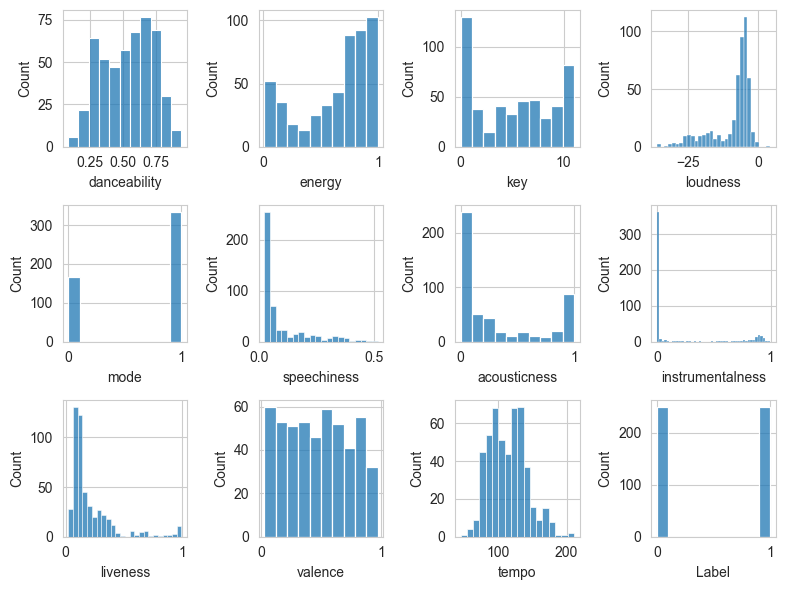

In [4]:
# Check distribution
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(data[col], kde=False, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.savefig('Distribution.eps', format='eps')
plt.show()

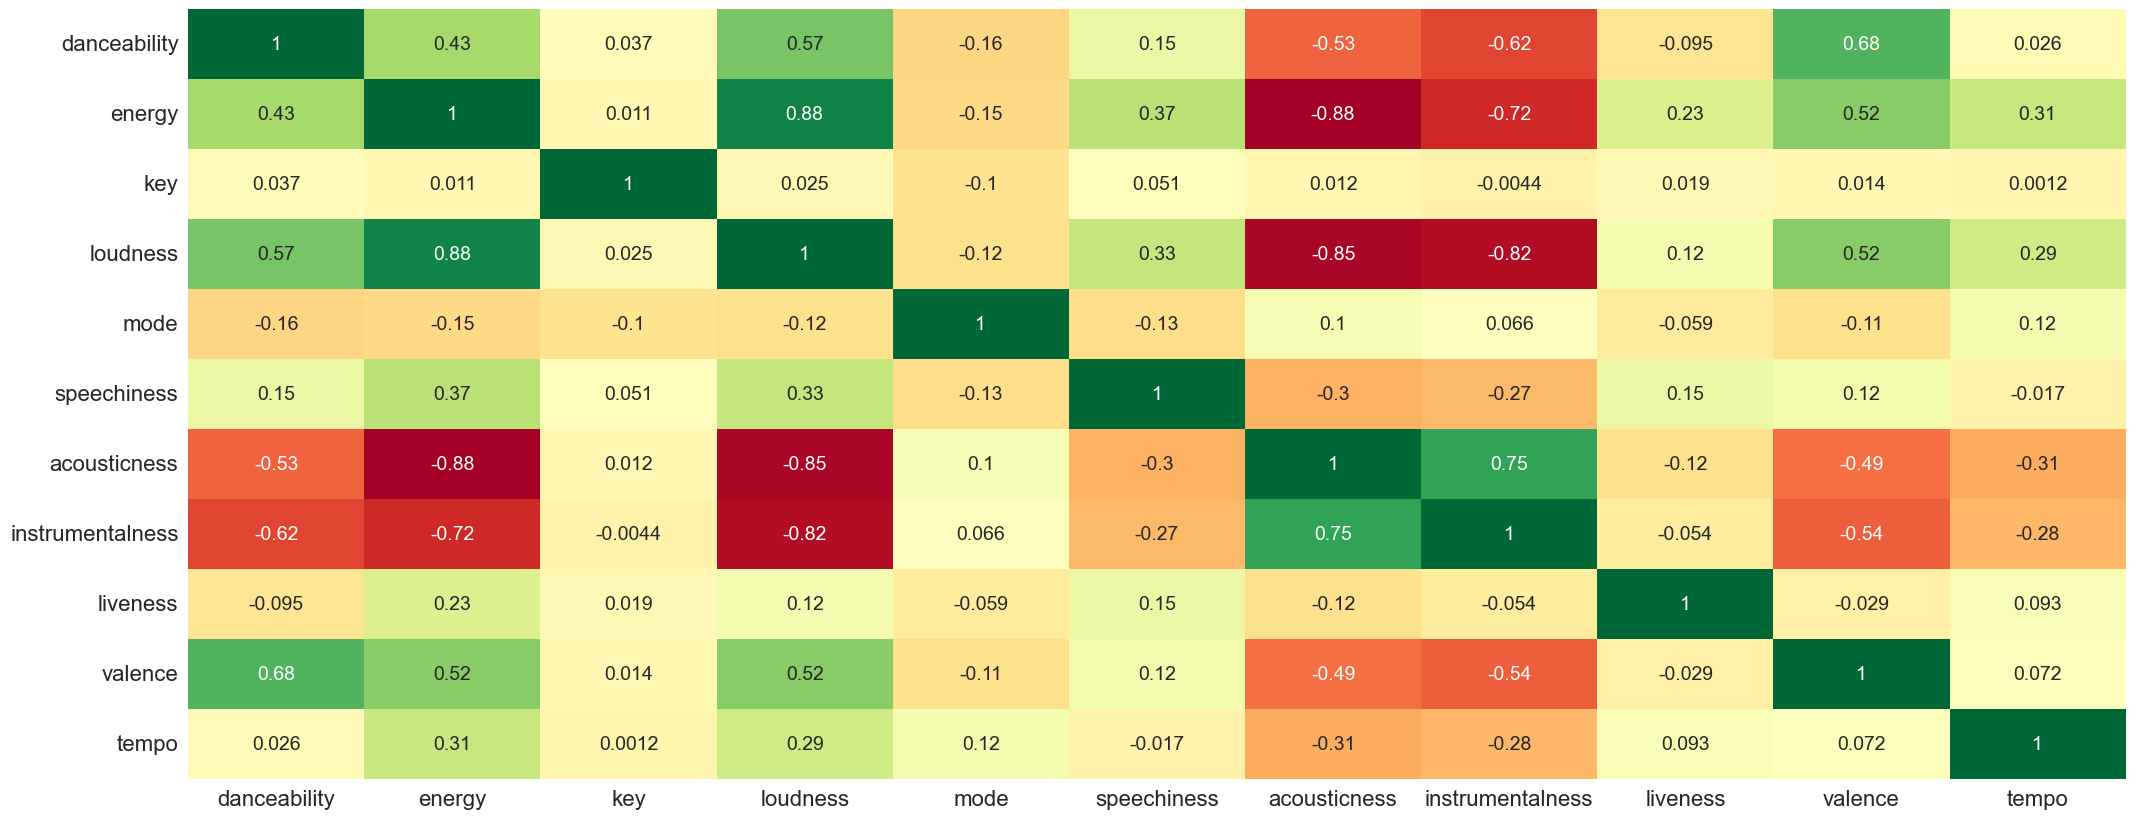

In [5]:
# heat map of correlation
features = data.drop([] + ["Label"], axis=1)
plt.figure(figsize=(25,10))
sns.heatmap(features.corr(), annot=True, cmap='RdYlGn', cbar=False, annot_kws={"size": 14})
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Correlation.eps', format='eps')

In [5]:
# Create the pairplot with scatter plots for off-diagonal and probability distributions (KDE) on diagonal
#sns.pairplot(data, hue = "Label", diag_kws={'fill': False}, corner=True)

## Transforming data - courtesy of Tove

In [6]:
vars_to_transform = [
    "danceability",
    "energy",
    "speechiness",
    "acousticness",
    "liveness",
    "valence",
]

transformed_data = data.copy()
transformed_data[vars_to_transform] = transformed_data[vars_to_transform].transform(logit)

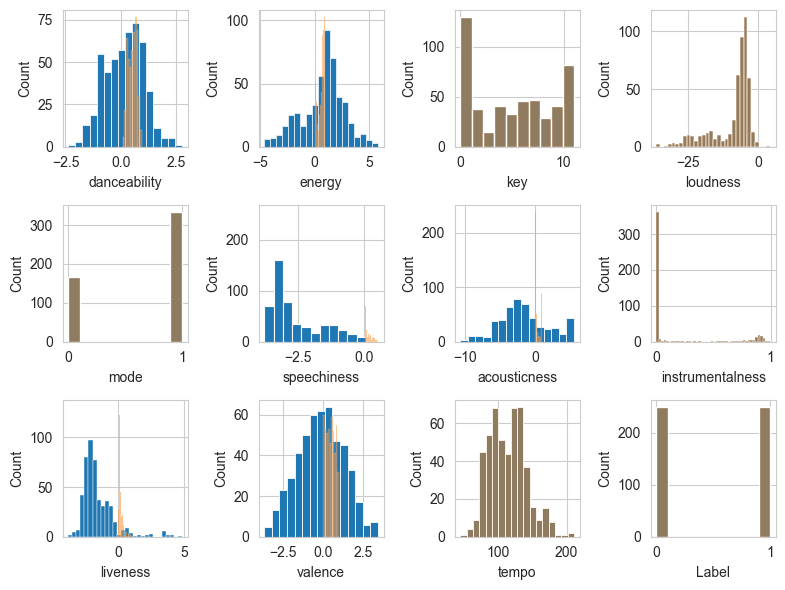

In [7]:
# Check distribution again, comparing transformed (blue) with initial (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(data.columns):
    sns.histplot(transformed_data[col], ax=axes[i],alpha=1)
    sns.histplot(data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [8]:
#sns.pairplot(transformed_data[vars_to_transform + ["Label"]], hue = "Label", diag_kws={'fill': False})

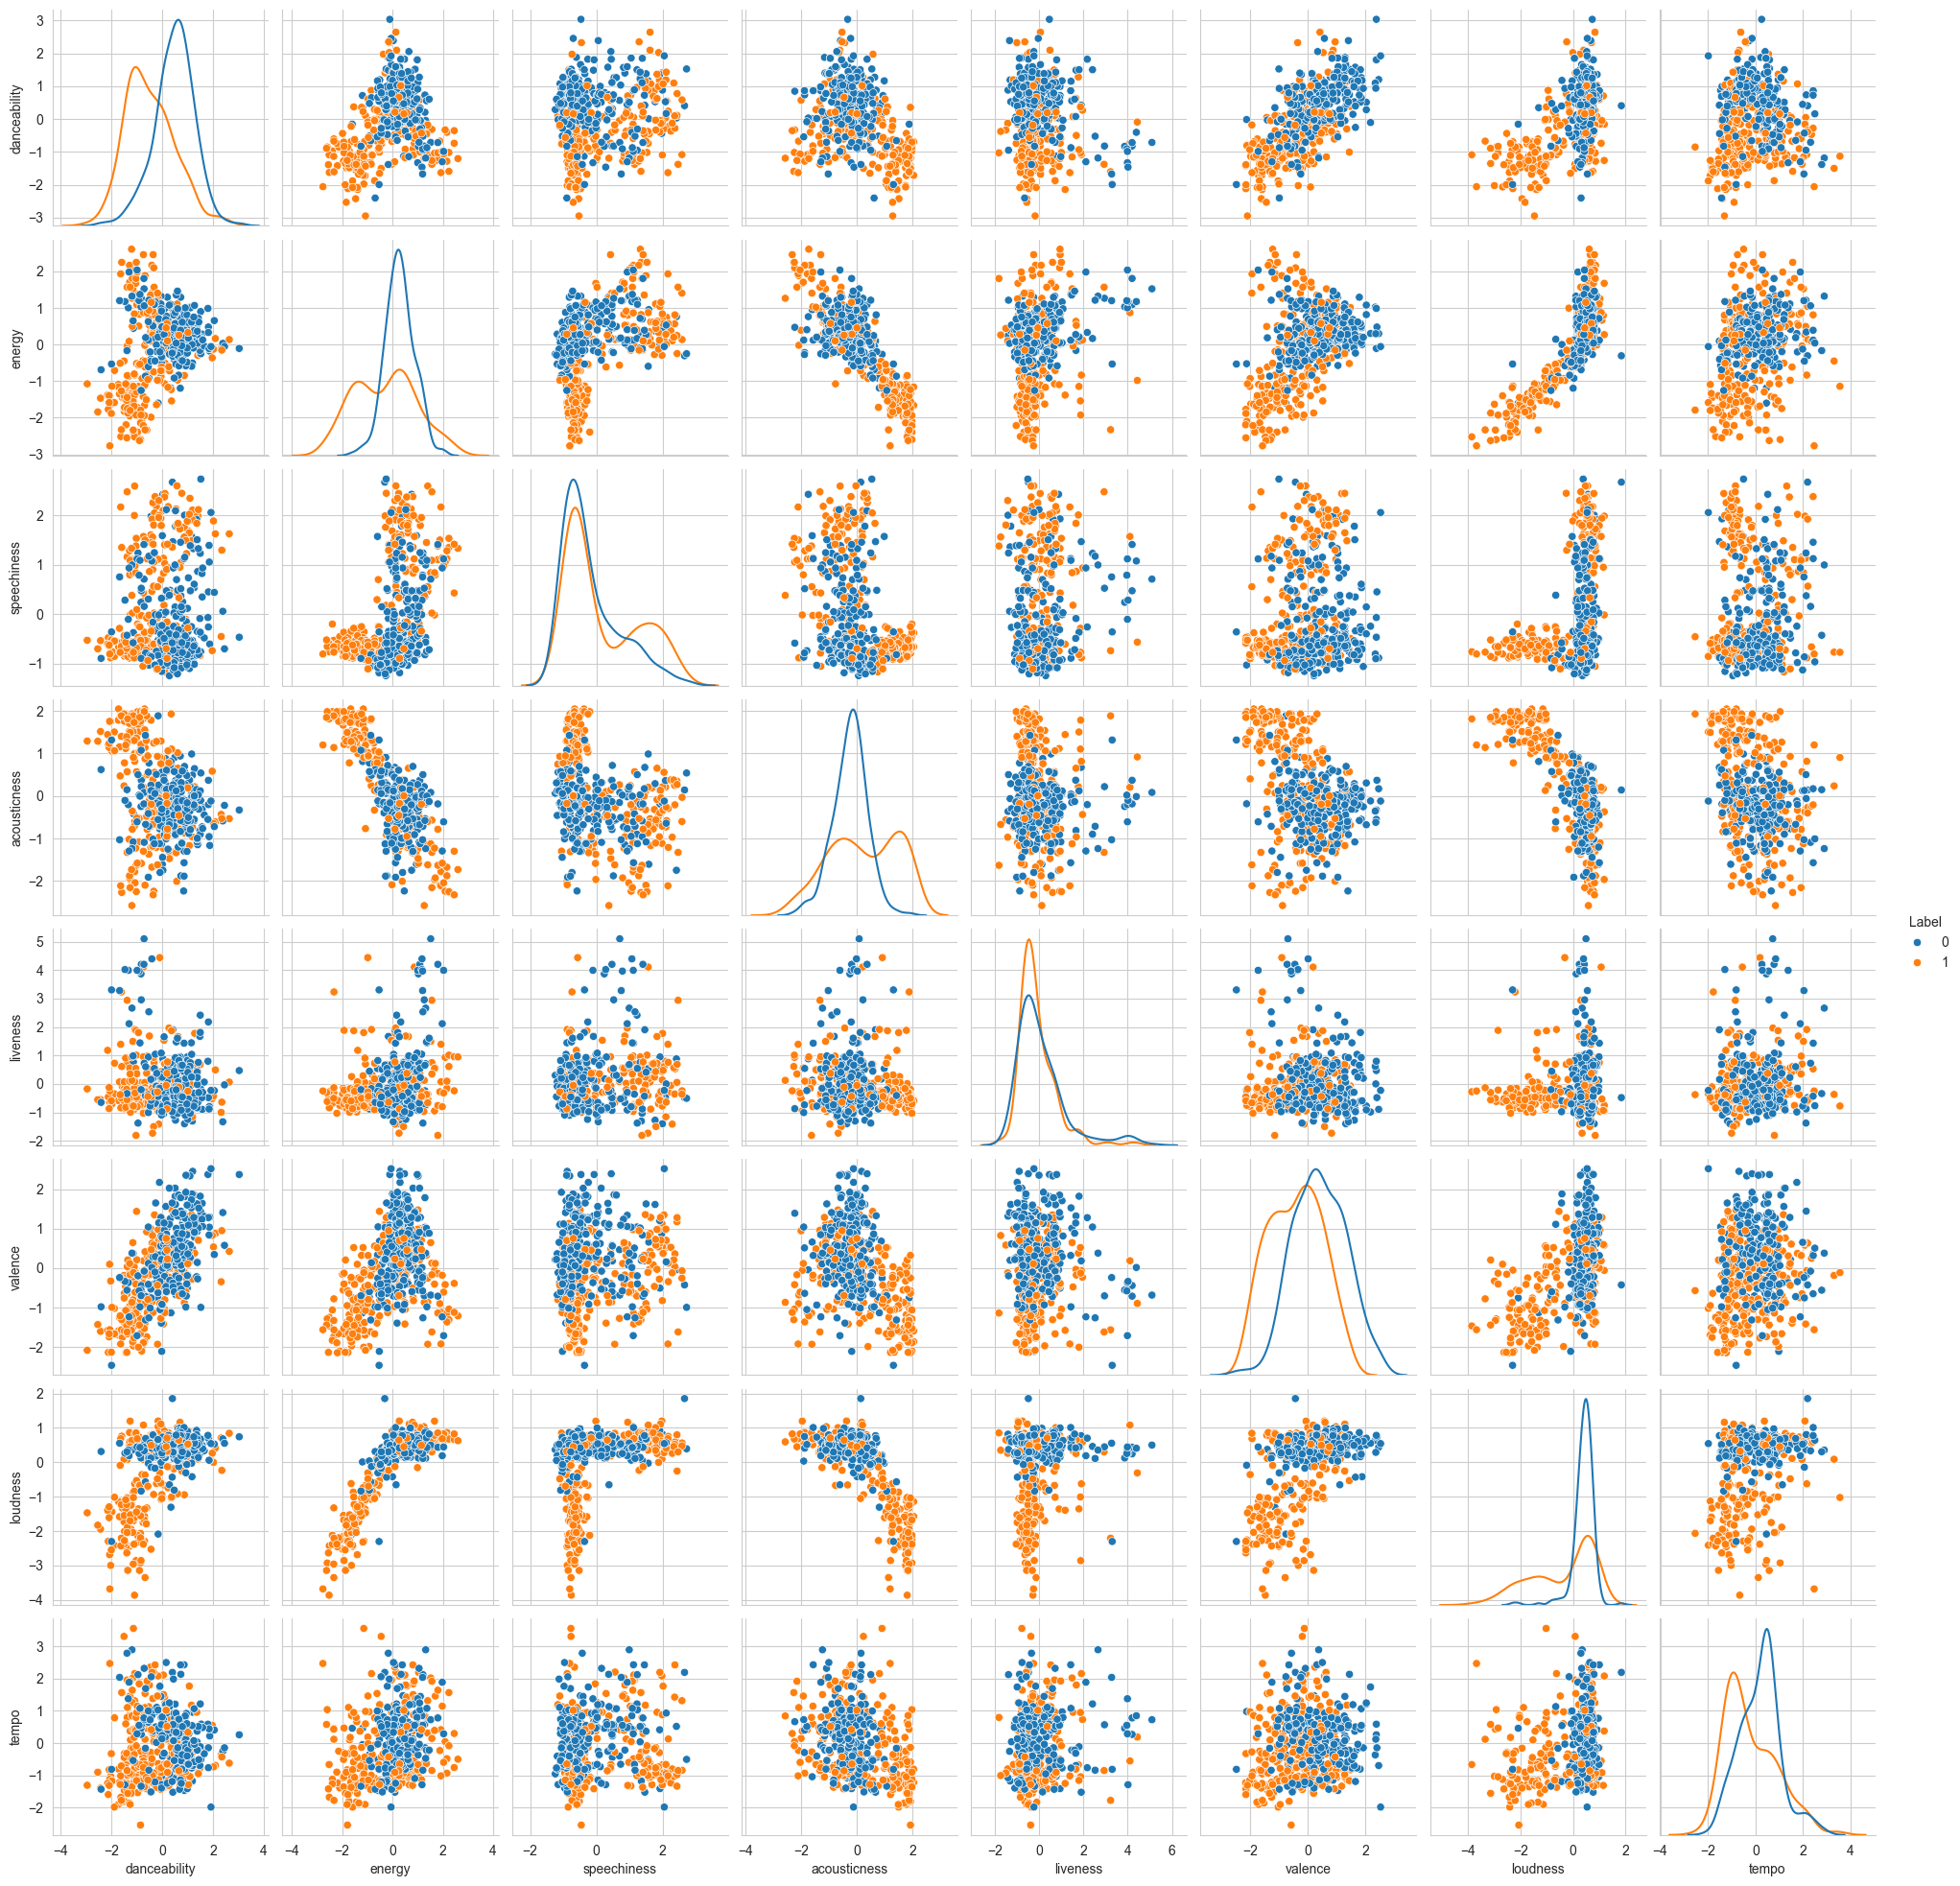

In [8]:
scaled_data = transformed_data.copy()
scaled_data[vars_to_transform + ["loudness", "tempo"]] = preprocessing.scale(
    scaled_data[vars_to_transform + ["loudness", "tempo"]]
)
sns.pairplot(scaled_data[vars_to_transform + ["loudness", "tempo", "Label"]], hue = "Label", diag_kws={'fill': False})

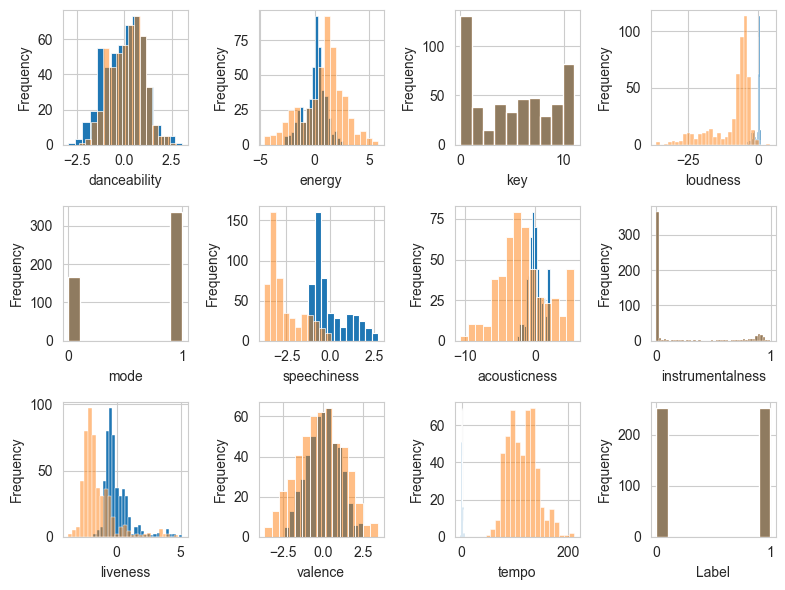

In [9]:
# Check distribution again, comparing scaled (blue) with transformed (orange)
fig, axes = plt.subplots(3, 4, figsize=(8, 6))
axes = axes.flatten()

for i, col in enumerate(scaled_data.columns):
    sns.histplot(scaled_data[col], ax=axes[i],alpha=1)
    sns.histplot(transformed_data[col], ax=axes[i], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
all_predictors = scaled_data.drop([] + ["Label"], axis=1)
response = scaled_data["Label"]

# We drop_first because one of the variables in each of key,
# mode is determined by the values of the others
# (for example mode != 0 implies mode = 1)
encoded_data = pd.get_dummies(
    all_predictors, columns=["key", "mode"], drop_first=True
)

predictors_train, predictors_test, response_train, response_test = train_test_split(encoded_data, response, test_size=0.3, random_state=8)

<Axes: >

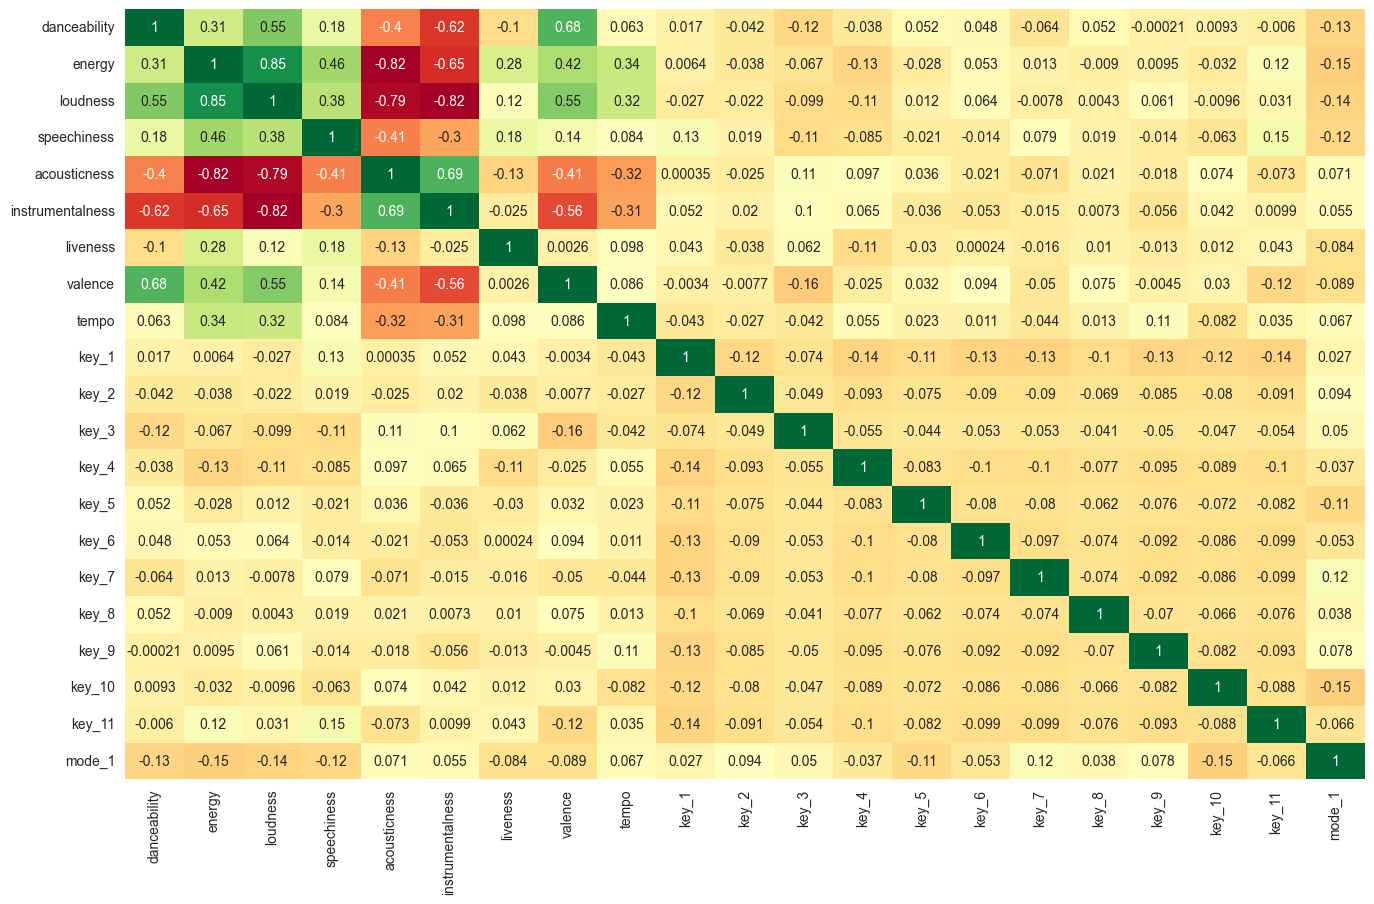

In [11]:
# heat map of correlation
plt.figure(figsize=(16,10))
sns.heatmap(predictors_train.corr(), annot=True, cmap='RdYlGn', cbar=False)

There are some redundancies.

# <span style="color:red">Intermediate conclusions</span>

1. The outcome of the model "accuracy" on the test split is *higly!!* dependent on the randomization seed when splitting the data into train/test sets.
2. The combination of logit transform and scaling has a good effect on recall and overall accuracy.
3. Checking for correlation among independent variables and proactively removing dependent features is not needed, backward feature selection works well.
4. Reducing the number of features only marginally reduce accuracy, thus it is highly desired to reduce the number of features to improve generalization and avoid overfitting. 
5. To improve the model, tuning hyperparameters can be attempted.

### Attempting to find a trend between selected features and accuracies across feature set sizes and randomization seed, while also comparing the performance of default hyperparameters with the performance when adjusting gamma and C. This is to avoid inflating the confidence in a model's accuracy based on the performance on a random small test set.

In [14]:
C_grid = [0.001, 0.01, 0.1, 1, 10, 100]
gamma_grid = [0.001, 0.01, 0.1, 1, 10, 100]

NUM_TRIALS = 5

# Initialize dictionaries for storing results
accuracy_orig_dict = {}
accuracy_mod_dict = {}
bestfeatures = {}

for n in range(NUM_TRIALS):
    kf = KFold(n_splits=5, shuffle=True, random_state=n)
    accuracy_orig_dict[n] = {}
    accuracy_mod_dict[n] = {}
    bestfeatures[n] = {}
    for i in range(1, predictors_train.shape[1] + 1):
        bestfeatures[n][i] = {}
        accuracy_orig_dict[n][i] = {}
        accuracy_mod_dict[n][i] = {}
        
        # KFold cross-validation: Split the dataset into k folds
        for fold, (train_index, test_index) in enumerate(kf.split(encoded_data)):
            print(f'{i} features, fold = {fold}..', end='')
            
            # Split the data based on the current fold
            predictors_train, predictors_test = encoded_data.iloc[train_index], encoded_data.iloc[test_index]
            response_train, response_test = response.iloc[train_index], response.iloc[test_index]
            
            if i == predictors_train.shape[1]:
                # All features
                bestfeatures[n][i][fold] = predictors_test.columns
                model, accuracy = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, metrics='None')
                
                n_features = predictors_train.shape[1]
                X_variance = predictors_train.var().mean()
                gamma_value = 1 / (n_features * X_variance)
                
                accuracy_mod_dict[n][i][fold] = {}
                for k in range(len(C_grid)):
                    accuracy_mod_dict[n][i][fold][k] = {}
                    for l in range(len(gamma_grid)):
                        _, accuracy_mod = svm_model('rbf', predictors_train, response_train, predictors_test, response_test, c=C_grid[k], gamma=gamma_grid[l], metrics='None')
                        accuracy_mod_dict[n][i][fold][k][l] = accuracy_mod
                
                accuracy_orig_dict[n][i][fold] = accuracy
                print('Training DONE.')
            
            else:
                # Feature selection
                sfs = SequentialFeatureSelector(estimator=SVC(kernel='rbf'), n_features_to_select=i, direction='backward')
                sfs.fit(predictors_train, response_train)
                
                selected_features = sfs.get_support()  # Boolean mask of selected features    
                predictors_train_sfs = predictors_train.loc[:, selected_features]
                predictors_test_sfs = predictors_test.loc[:, selected_features]
                
                print('Predictors DONE.. ', end='')
                bestfeatures[n][i][fold] = predictors_test_sfs.columns
                
                model, accuracy = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, metrics='None')
                
                n_features = predictors_train_sfs.shape[1]
                X_variance = predictors_train_sfs.var().mean()
                gamma_value = 1 / (n_features * X_variance)
                
                accuracy_mod_dict[n][i][fold] = {}
                for k in range(len(C_grid)):
                    accuracy_mod_dict[n][i][fold][k] = {}
                    for l in range(len(gamma_grid)):
                        _, accuracy_mod = svm_model('rbf', predictors_train_sfs, response_train, predictors_test_sfs, response_test, c=C_grid[k], gamma=round(gamma_grid[l], 4), metrics='None')
                        accuracy_mod_dict[n][i][fold][k][l] = accuracy_mod
                
                accuracy_orig_dict[n][i][fold] = accuracy
                print('Training DONE.')

1 features, fold = 0..Predictors DONE.. Training DONE.
1 features, fold = 1..Predictors DONE.. Training DONE.
1 features, fold = 2..Predictors DONE.. Training DONE.
1 features, fold = 3..Predictors DONE.. Training DONE.
1 features, fold = 4..Predictors DONE.. Training DONE.
2 features, fold = 0..Predictors DONE.. Training DONE.
2 features, fold = 1..Predictors DONE.. Training DONE.
2 features, fold = 2..Predictors DONE.. Training DONE.
2 features, fold = 3..Predictors DONE.. Training DONE.
2 features, fold = 4..Predictors DONE.. Training DONE.
3 features, fold = 0..Predictors DONE.. Training DONE.
3 features, fold = 1..Predictors DONE.. Training DONE.
3 features, fold = 2..Predictors DONE.. Training DONE.
3 features, fold = 3..Predictors DONE.. Training DONE.
3 features, fold = 4..Predictors DONE.. Training DONE.
4 features, fold = 0..Predictors DONE.. Training DONE.
4 features, fold = 1..Predictors DONE.. Training DONE.
4 features, fold = 2..Predictors DONE.. Training DONE.
4 features

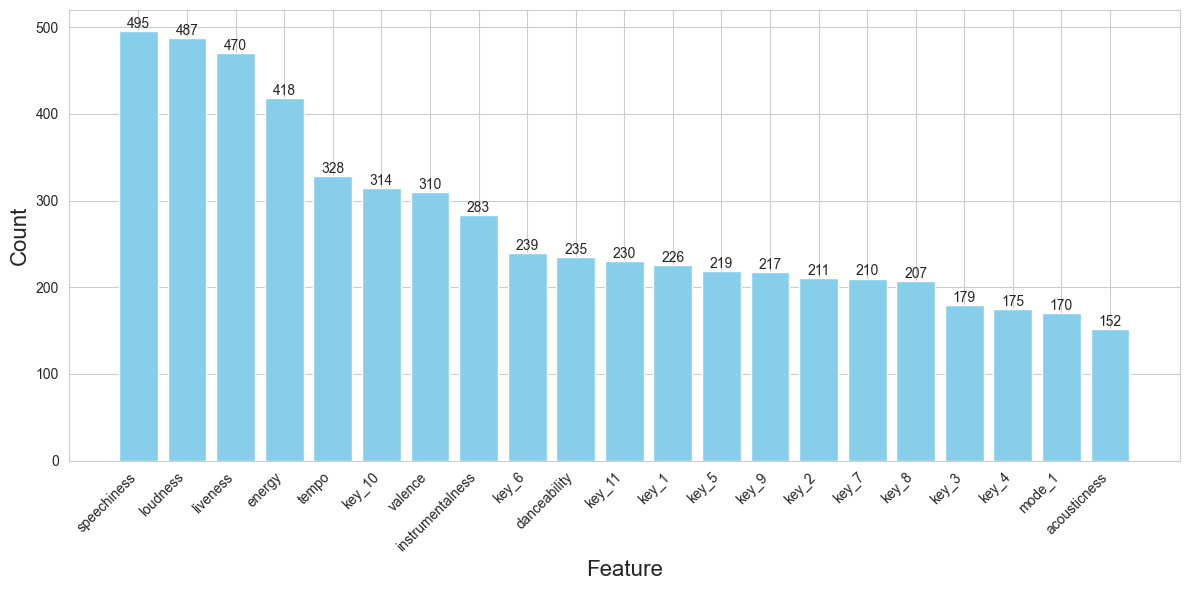

In [16]:
# Gather all features selected across folds and different numbers of features
all_features = []
for trial in bestfeatures:
    for feature in bestfeatures[trial]:
        for fold in bestfeatures[trial][feature]:
            all_features.extend(bestfeatures[trial][feature][fold])

# Count the occurrences of each feature
feature_counts = Counter(all_features)

# Sort features by the number of times they were selected (descending order)
sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
features, counts = zip(*sorted_features)

# Create a bar plot to visualize the most selected features
plt.figure(figsize=(12, 6))
plt.bar(features, counts, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Count', fontsize=16)

# Add the counts on top of the bars
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.tight_layout()

# Save the plot to a file
plt.savefig('FeatureCount_all.eps', format='eps')

# Display the plot
plt.show()

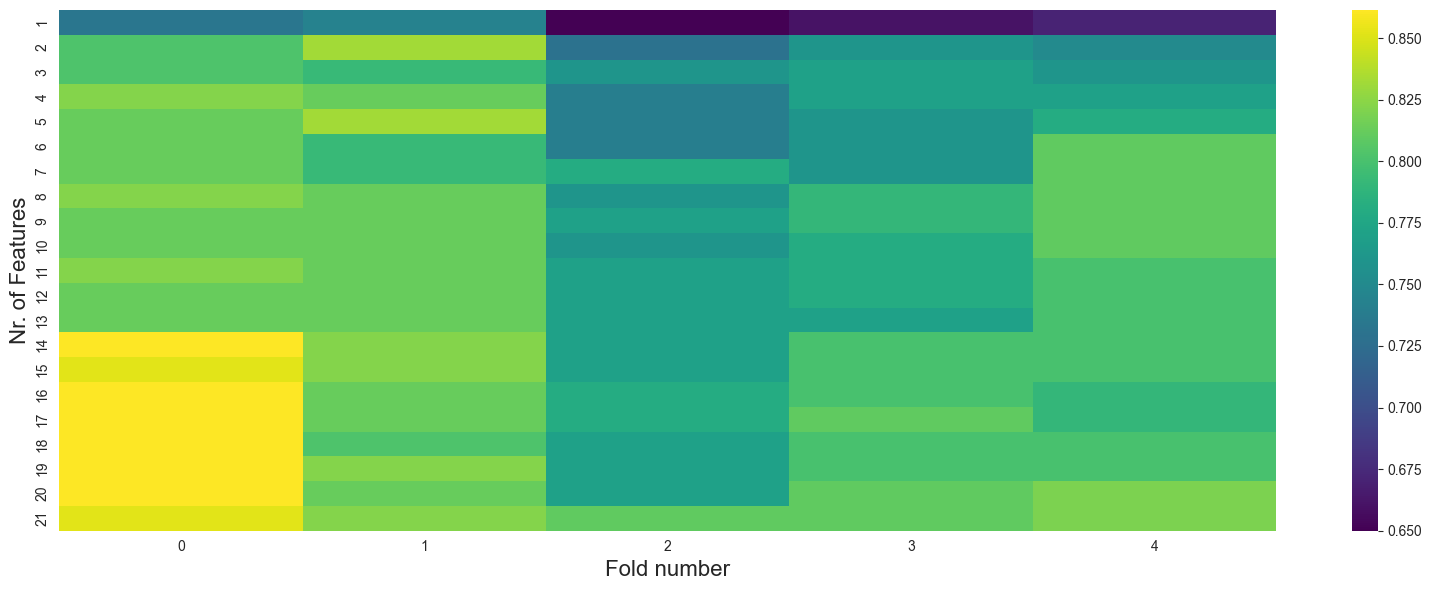

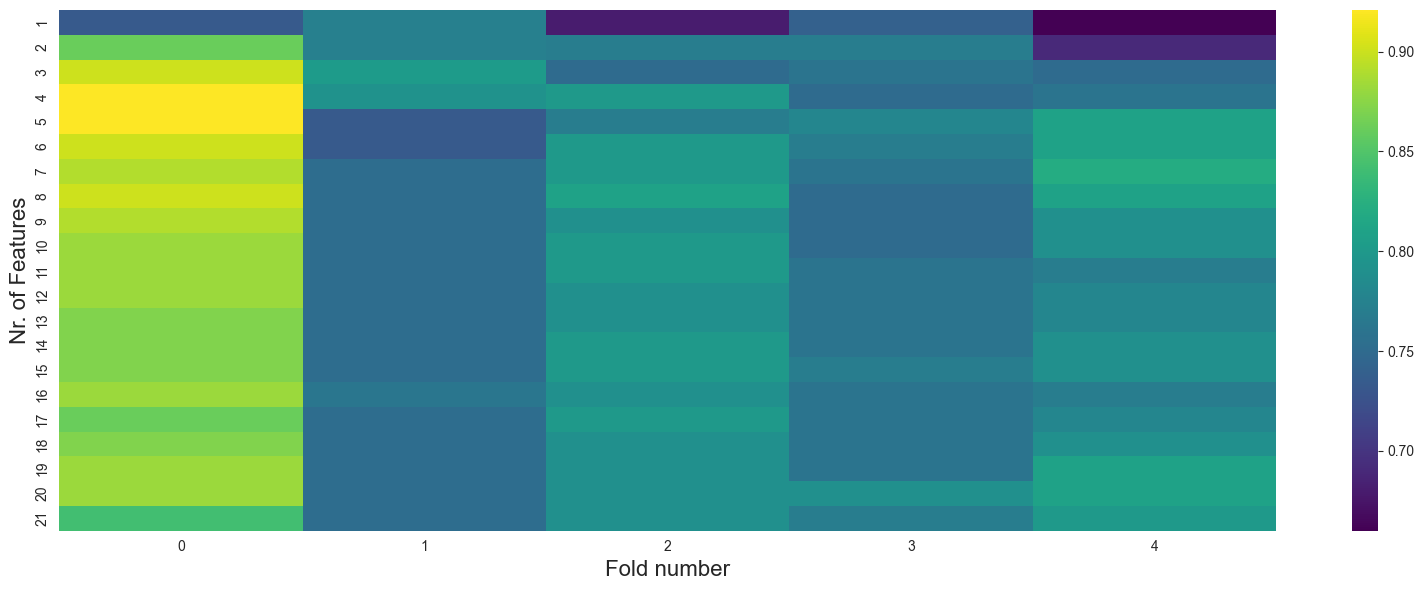

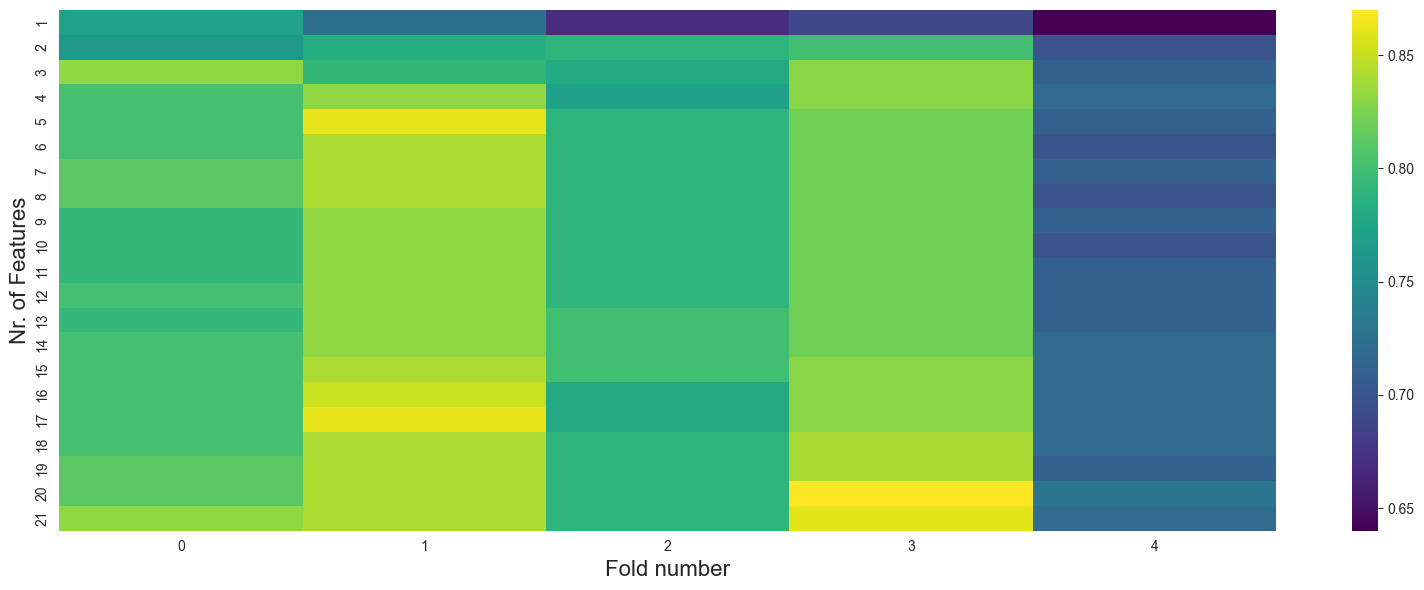

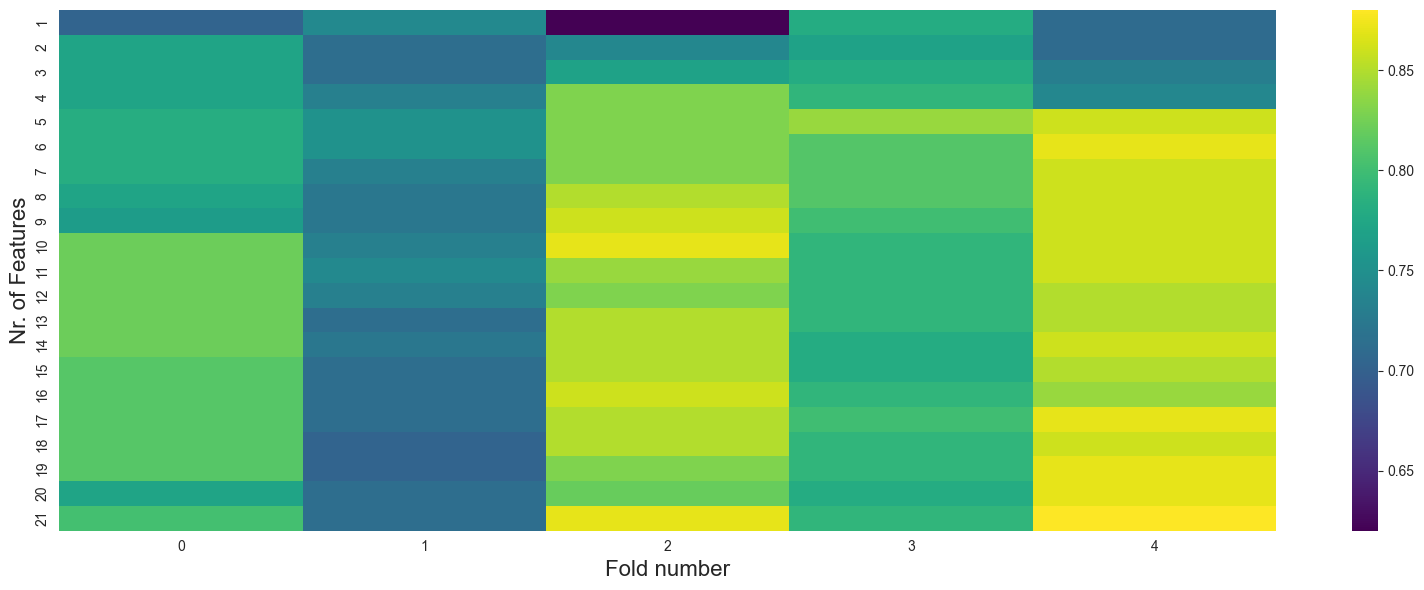

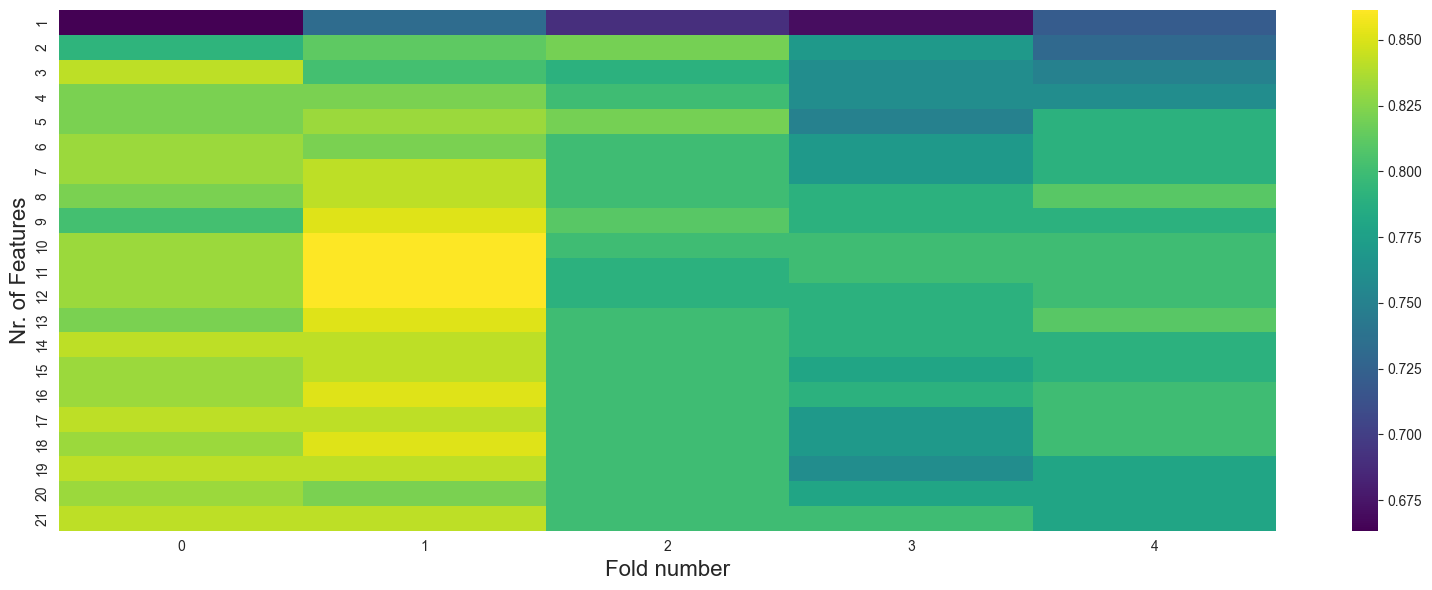

In [17]:
for n in range(NUM_TRIALS):    
    n_features = sorted(accuracy_orig_dict[n].keys())  # Sorted number of features
    fold_nrs = range(5)
    
    # Create a 2D array (Z) where each row corresponds to a fold and each column corresponds to a number of features
    Z = np.array([[accuracy_orig_dict[n][n_feature][fold] for n_feature in n_features] for fold in fold_nrs])
    
    # Create a heatmap
    plt.figure(figsize=(16, 6))
    sns.heatmap(Z.T, xticklabels=fold_nrs, yticklabels=n_features, cmap='viridis', annot=False)
    plt.xlabel('Fold number', fontsize=16)  # Updated label to 'Fold number'
    plt.ylabel('Nr. of Features', fontsize=16)
    plt.tight_layout()
    
    # Save the heatmap to a file
    plt.savefig('AccuracyHeatmap_all.eps', format='eps')
    
    # Display the heatmap
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1
1


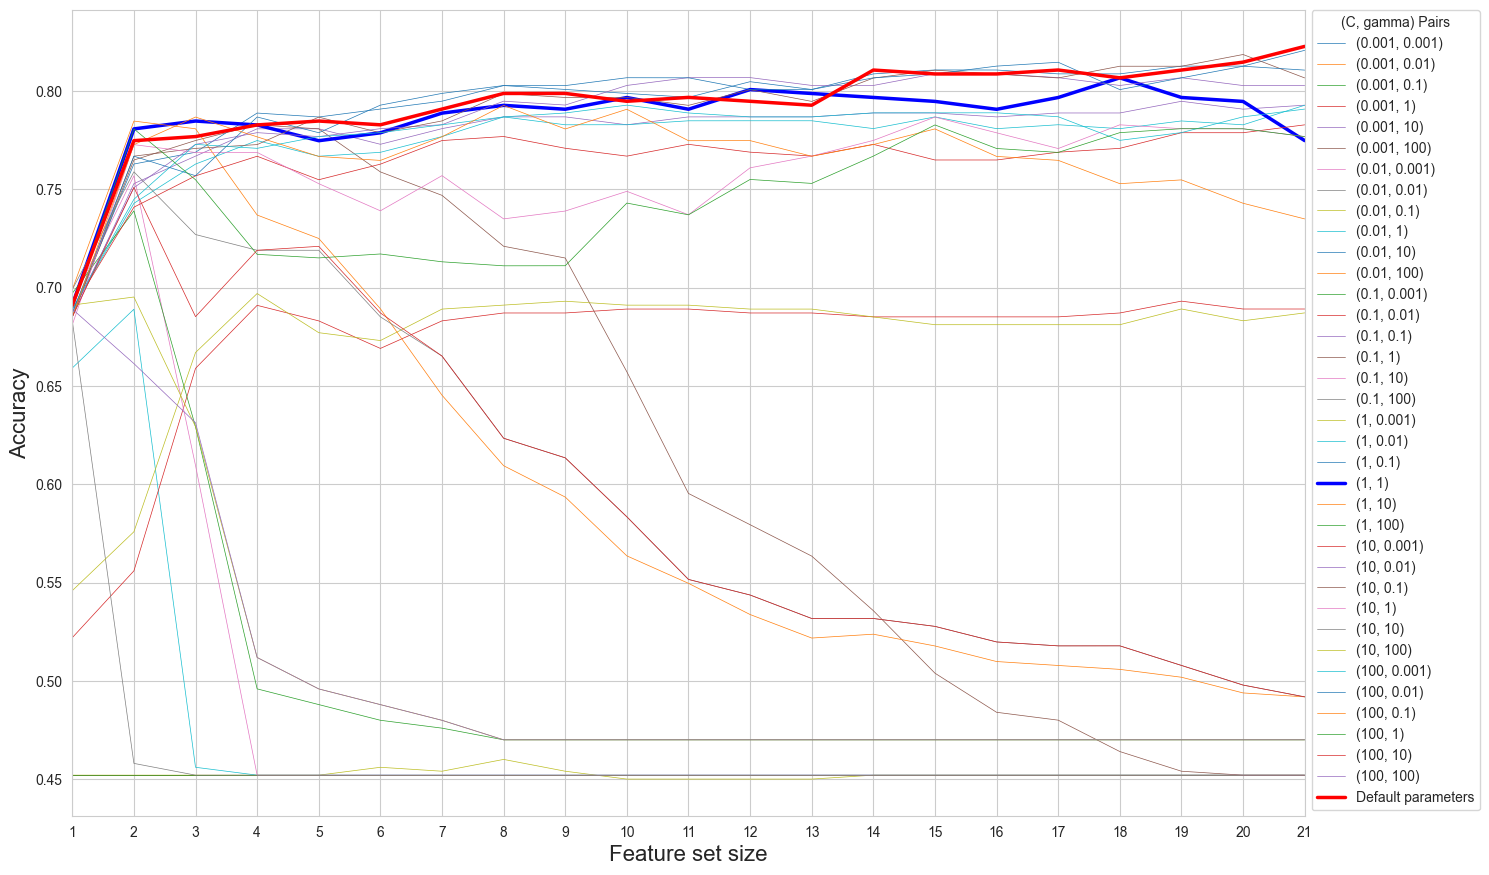

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1
1


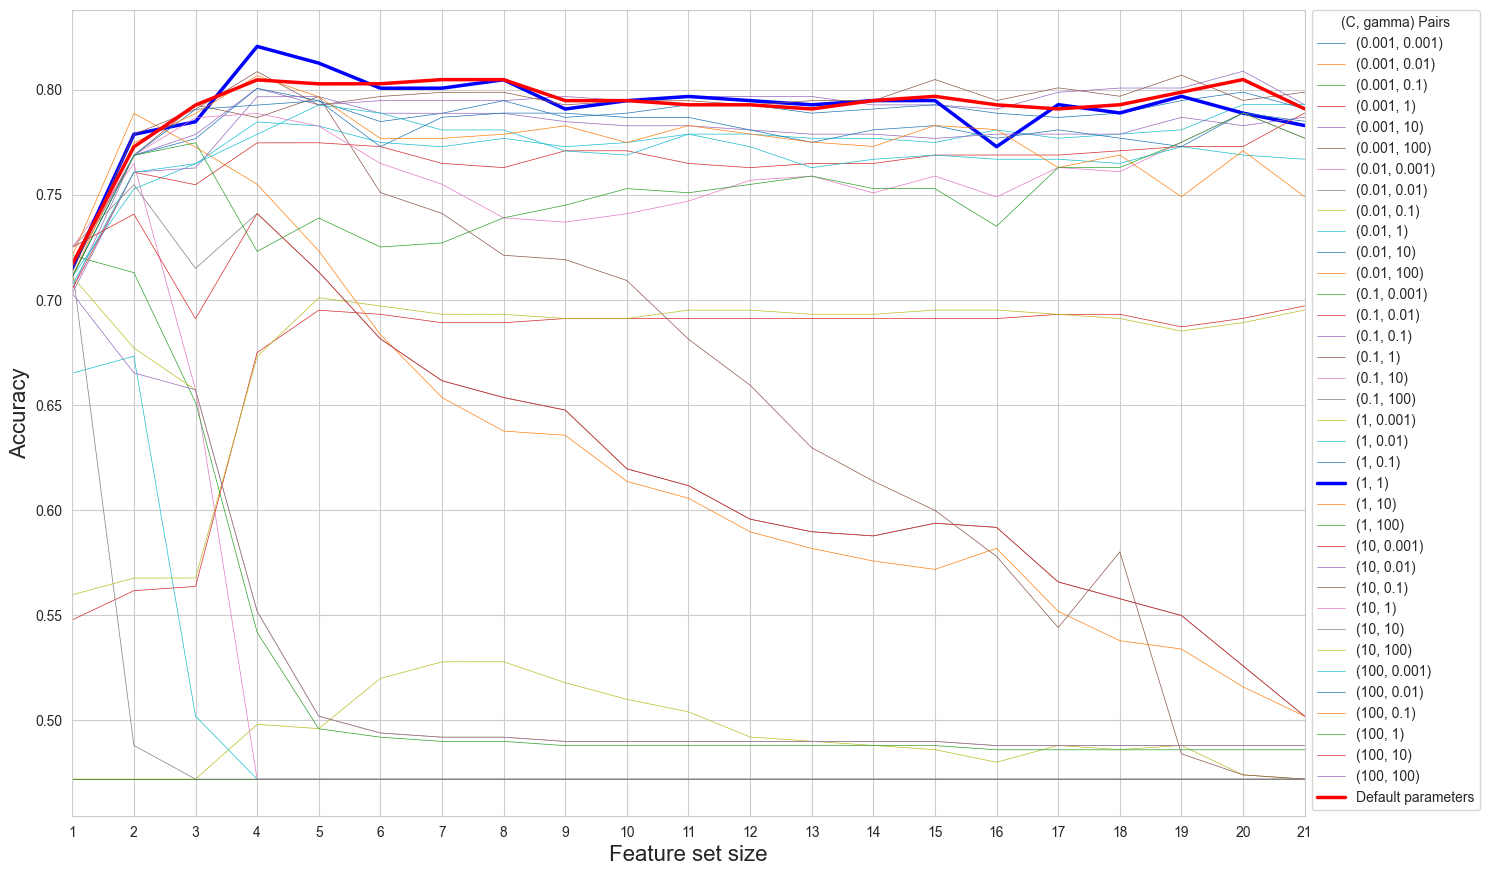

1
1


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


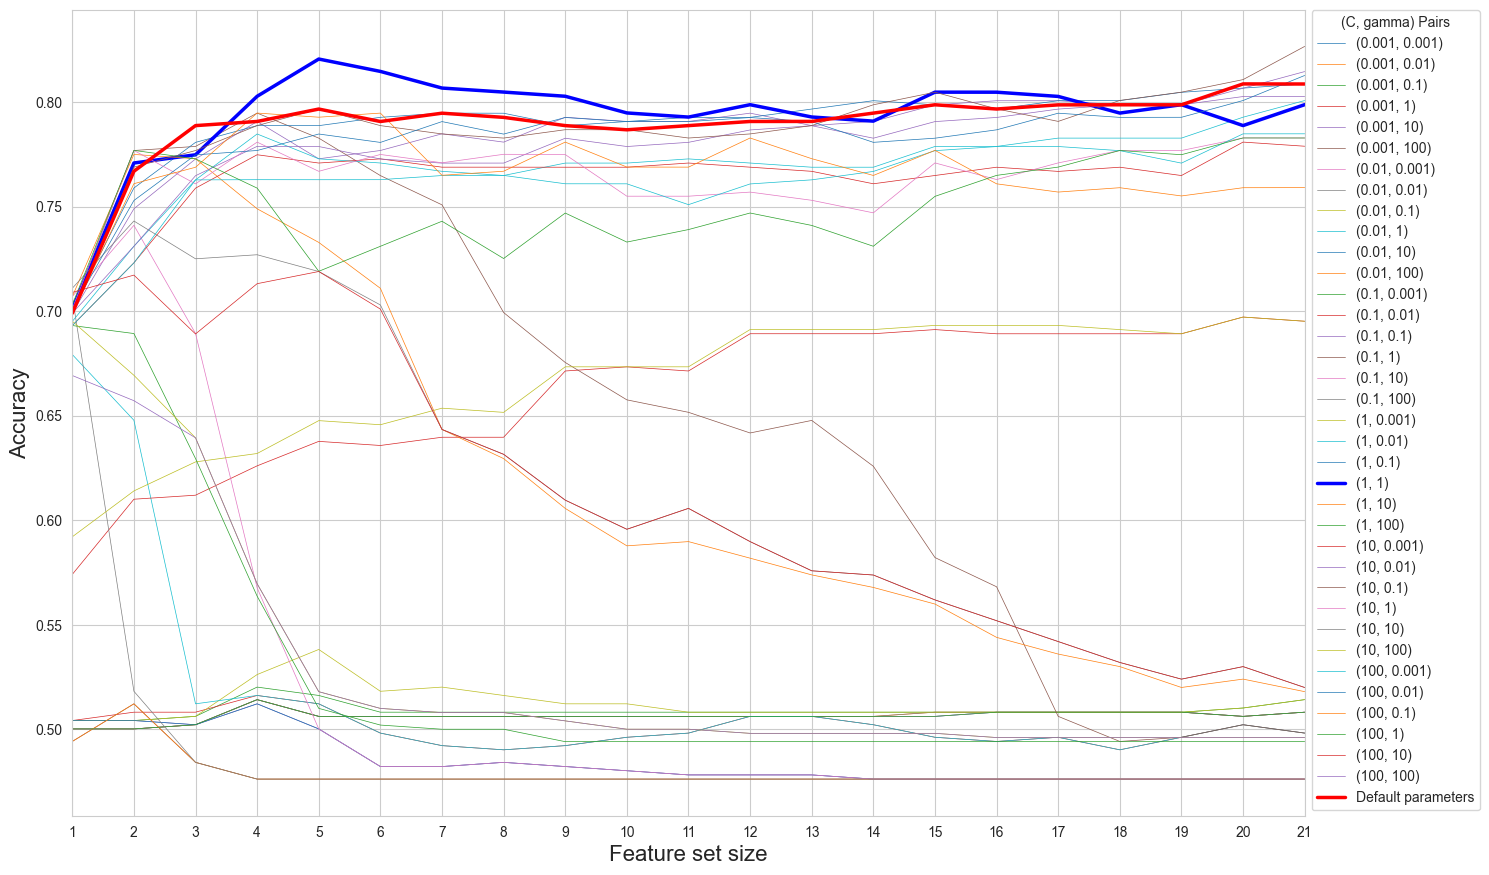

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1
1


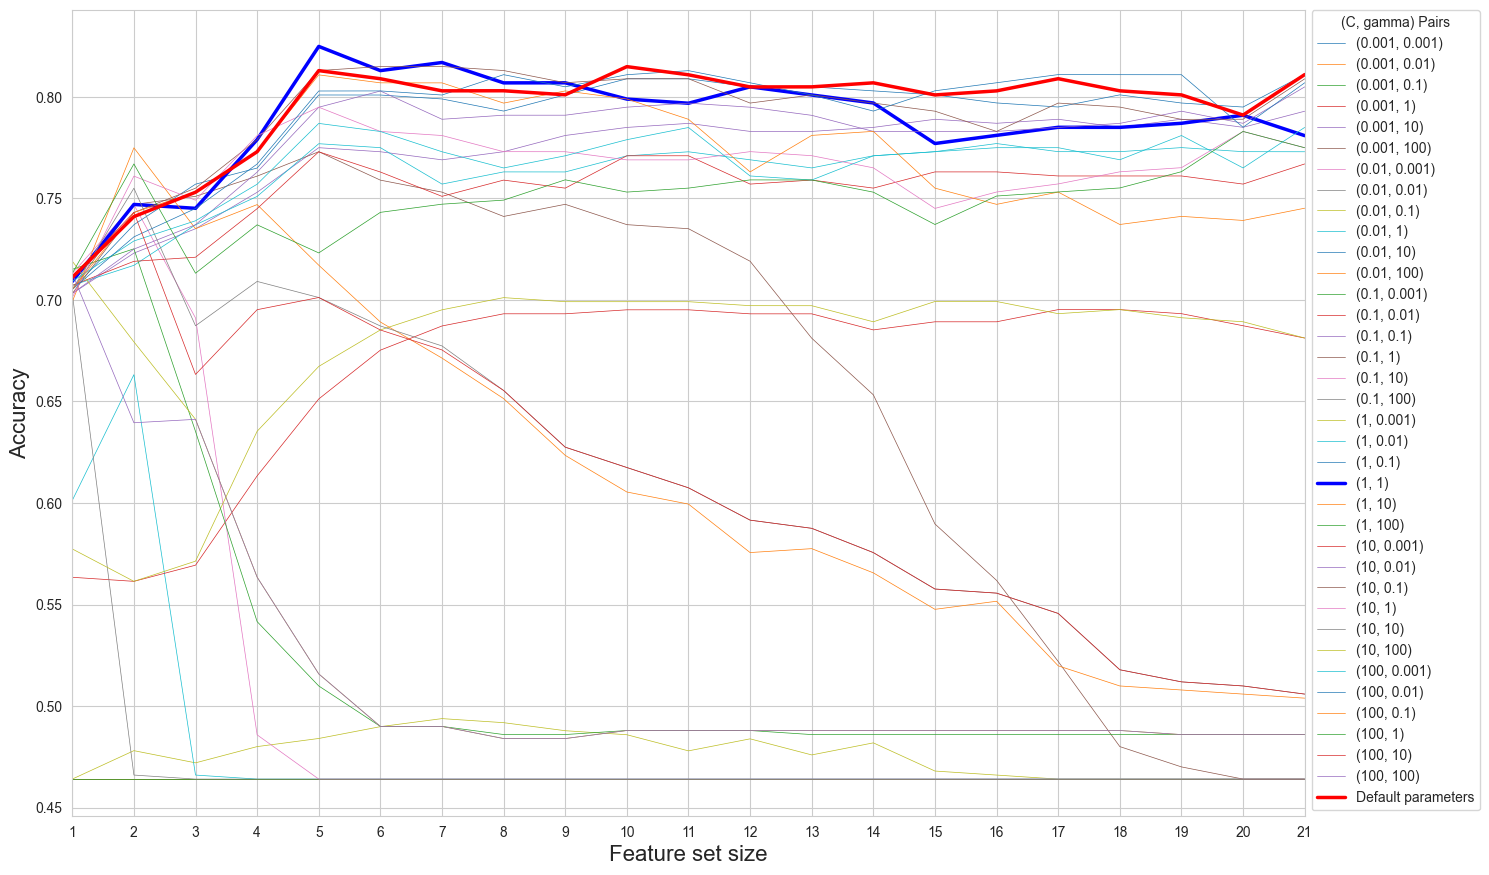

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1
1


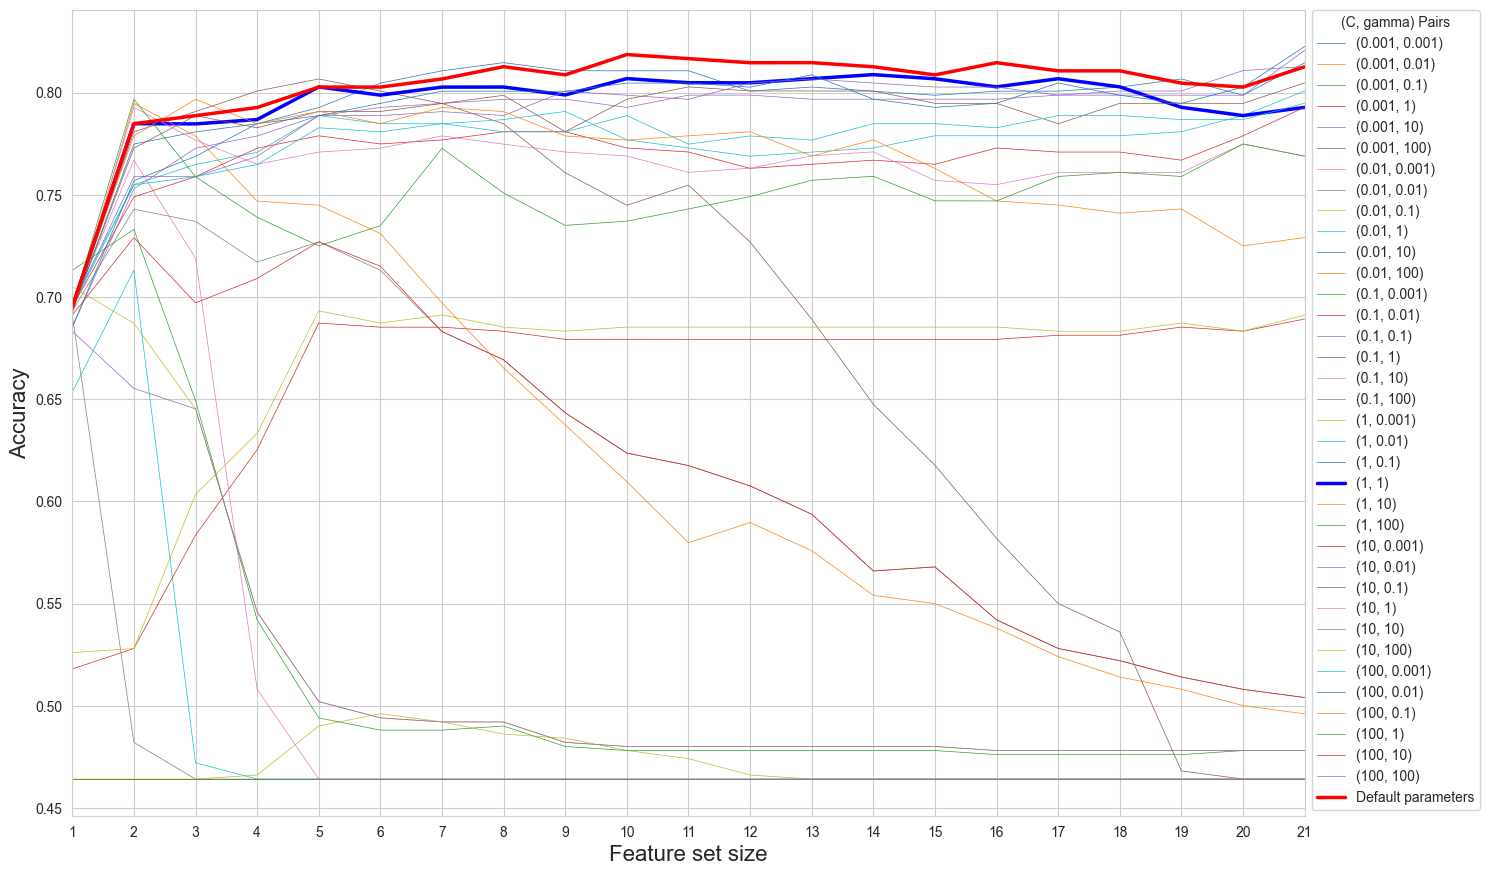

In [63]:
for n in range(5):
    # Calculate the average accuracy for original settings across folds
    average_dict_orig = {key: sum(values.values()) / len(values) for key, values in accuracy_orig_dict[n].items()}
    keys_orig = list(average_dict_orig.keys())    # Top-level keys (1 to 21)
    values_orig = list(average_dict_orig.values())  # Corresponding average values
    
    sum_dict_mod = {}
    
    # Iterate through accuracy_mod_dict to accumulate sums over folds
    for i, val_i in accuracy_mod_dict[n].items():
        sum_dict_mod[i] = {}
        for fold, val_fold in accuracy_mod_dict[n][i].items():  # Use 'fold' instead of 'seed'
            for k, val_k in accuracy_mod_dict[n][i][fold].items():
                if k not in sum_dict_mod[i]:
                    sum_dict_mod[i][k] = {}
                for l, val_l in accuracy_mod_dict[n][i][fold][k].items():
                    if l not in sum_dict_mod[i][k]:
                        sum_dict_mod[i][k][l] = 0
                    value = accuracy_mod_dict[n][i][fold][k][l]
                    sum_dict_mod[i][k][l] += value
    
    # Create the result dictionary for averages over the folds
    average_dict_mod = {}
    for i in sum_dict_mod:
        average_dict_mod[i] = {}
        for k in sum_dict_mod[i]:
            if k not in average_dict_mod[i]:
                average_dict_mod[i][k] = {}
            for l in sum_dict_mod[i][k]:
                # Calculate the average over folds
                average_dict_mod[i][k][l] = sum_dict_mod[i][k][l] / len(accuracy_mod_dict[n][i].items())
    
    plotc = 3
    plotgamma = 3
    
    print(C_grid[plotc])
    print(gamma_grid[plotgamma])
    
    # Plotting
    plt.figure(figsize=(15, 9.25))
    for k in average_dict_mod[1]:  # Use k from the first i
        for l in average_dict_mod[1][k]:  # Use l from the first i
            # Prepare x and y data for plotting
            x = list(average_dict_mod.keys())  # Feature set sizes (x-axis)
            y = [average_dict_mod[i][k][l] for i in x]  # Corresponding accuracies (y-axis)
    
            # Plot each hyperparameter pair (C, gamma)
            
            if k == plotc and l == plotgamma:
                plt.plot(x, y, label=f'({C_grid[k]}, {gamma_grid[l]})', linewidth=2.5, color='blue')
            else:
                plt.plot(x, y, label=f'({C_grid[k]}, {gamma_grid[l]})', linewidth=0.5)
    
    # Plot the accuracy for the default parameters
    plt.plot(keys_orig, values_orig, linewidth=2.5, color='red', label='Default parameters')
    
    # Labels, grid, and legend
    plt.xlabel('Feature set size', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(title='(C, gamma) Pairs', loc='upper left', ncol=1, bbox_to_anchor=(1, 1.008))
    plt.grid(True)
    plt.xlim(1, 21)
    plt.xticks(keys_orig)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'AccuracyHyperparameterVar{n}.eps', format='eps')
    
    # Show the plot
    plt.show()

Default hyperparameters are the best performing overall. C=1 and gamma=1 performs best at 4-5 feature set size:

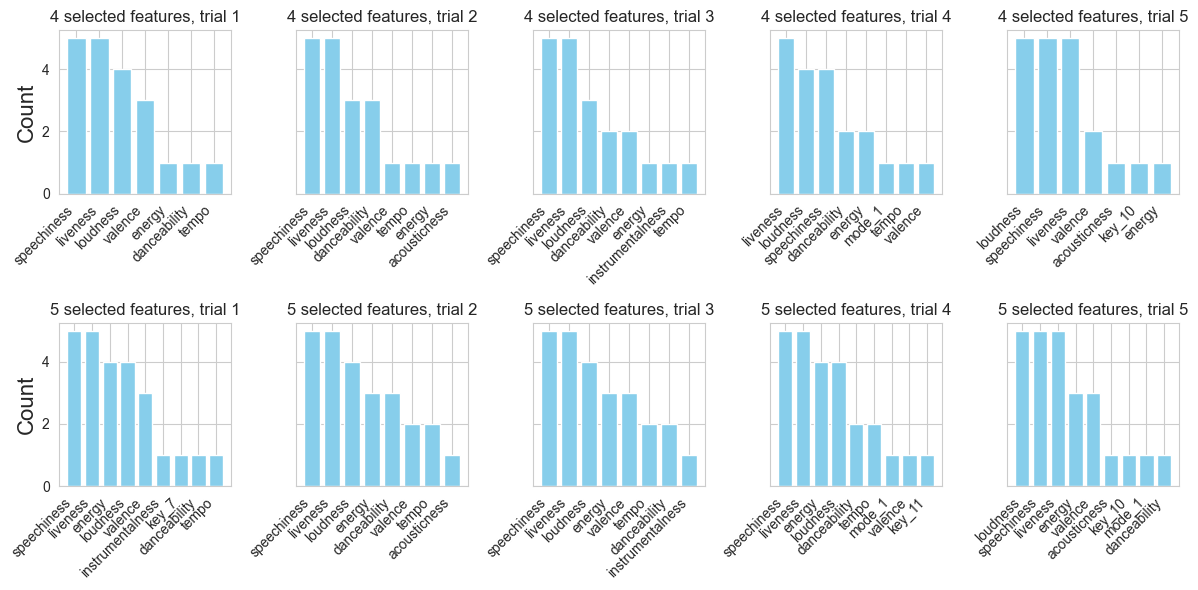

In [62]:
fig, axs = plt.subplots(2, 5, figsize=(12, 6), sharey=True)

for trial in range(5):
    all_features_4 = []
    all_features_5 = []
    for fold in bestfeatures[trial][4]:
        all_features_4.extend(bestfeatures[trial][4][fold])
    for fold in bestfeatures[trial][5]:
        all_features_5.extend(bestfeatures[trial][5][fold])
    
    feature_counts_4 = Counter(all_features_4)
    feature_counts_5 = Counter(all_features_5)
    
    sorted_categories_4 = sorted(feature_counts_4.items(), key=lambda x: x[1], reverse=True)
    sorted_categories_5 = sorted(feature_counts_5.items(), key=lambda x: x[1], reverse=True)
    
    categories_4, counts_4 = zip(*sorted_categories_4)
    categories_5, counts_5 = zip(*sorted_categories_5)
        
    axs[0, trial].bar(categories_4, counts_4, color='skyblue')
    axs[0, trial].set_title(f'4 selected features, trial {trial+1}')
    axs[0, trial].set_xticks(range(len(categories_4)))  # Set positions for ticks
    axs[0, trial].set_xticklabels(categories_4, rotation=45, ha='right')
    
    axs[1, trial].bar(categories_5, counts_5, color='skyblue')
    axs[1, trial].set_title(f'5 selected features, trial {trial+1}')
    axs[1, trial].set_xticks(range(len(categories_5)))  # Set positions for ticks
    axs[1, trial].set_xticklabels(categories_5, rotation=45, ha='right')
    
    if trial == 0:
        axs[0, trial].set_ylabel('Count', fontsize=16)
        axs[1, trial].set_ylabel('Count', fontsize=16)
    
# Adjust layout to prevent label overlap and save the plot
plt.tight_layout()
plt.savefig('FeatureImportance_45.eps', format='eps')
plt.show()


I chose 5 features: 'speechiness', 'liveness', 'loudness', 'energy', 'valence' 

# <span style="color:red">Comparing different 5-feature models</span>

In [54]:
final_features = ['speechiness', 'liveness', 'energy', 'loudness', 'valence']
accuracy_final_dict = {}

NUM_TRIALS = 50
k_values = [2, 5, 20, 50, 100, 501]

for i in range(NUM_TRIALS):
    accuracy_final_dict[i+1] = {}
    # Loop over different k values
    for k in k_values:
        accuracy_final_dict[i+1][k] = {}
        
        # Set up the k-fold cross-validation
        kf = KFold(n_splits=k, shuffle=True, random_state=i) 
        
        fold_index = 0  # To track the fold number
        for train_index, test_index in kf.split(encoded_data):
            print(f'Trial = {i+1}, K = {k}, fold = {fold_index + 1}/{k}')

            predictors_train_final = encoded_data[final_features].iloc[train_index]
            predictors_test_final = encoded_data[final_features].iloc[test_index]
            response_train_final = response.iloc[train_index]
            response_test_final = response.iloc[test_index]
            
            # Train the SVM model and compute accuracy for both sets of final features
            model, accuracy = svm_model('rbf', predictors_train_final, response_train_final, predictors_test_final, response_test_final, metrics='None', c=1, gamma=1)
            
            # Store the accuracies for each fold
            accuracy_final_dict[i+1][k][fold_index] = accuracy
            
            fold_index += 1  # Increment fold index

Trial = 1, K = 2, fold = 1/2
Trial = 1, K = 2, fold = 2/2
Trial = 1, K = 5, fold = 1/5
Trial = 1, K = 5, fold = 2/5
Trial = 1, K = 5, fold = 3/5
Trial = 1, K = 5, fold = 4/5
Trial = 1, K = 5, fold = 5/5
Trial = 1, K = 20, fold = 1/20
Trial = 1, K = 20, fold = 2/20
Trial = 1, K = 20, fold = 3/20
Trial = 1, K = 20, fold = 4/20
Trial = 1, K = 20, fold = 5/20
Trial = 1, K = 20, fold = 6/20
Trial = 1, K = 20, fold = 7/20
Trial = 1, K = 20, fold = 8/20
Trial = 1, K = 20, fold = 9/20
Trial = 1, K = 20, fold = 10/20
Trial = 1, K = 20, fold = 11/20
Trial = 1, K = 20, fold = 12/20
Trial = 1, K = 20, fold = 13/20
Trial = 1, K = 20, fold = 14/20
Trial = 1, K = 20, fold = 15/20
Trial = 1, K = 20, fold = 16/20
Trial = 1, K = 20, fold = 17/20
Trial = 1, K = 20, fold = 18/20
Trial = 1, K = 20, fold = 19/20
Trial = 1, K = 20, fold = 20/20
Trial = 1, K = 50, fold = 1/50
Trial = 1, K = 50, fold = 2/50
Trial = 1, K = 50, fold = 3/50
Trial = 1, K = 50, fold = 4/50
Trial = 1, K = 50, fold = 5/50
Trial = 1, 

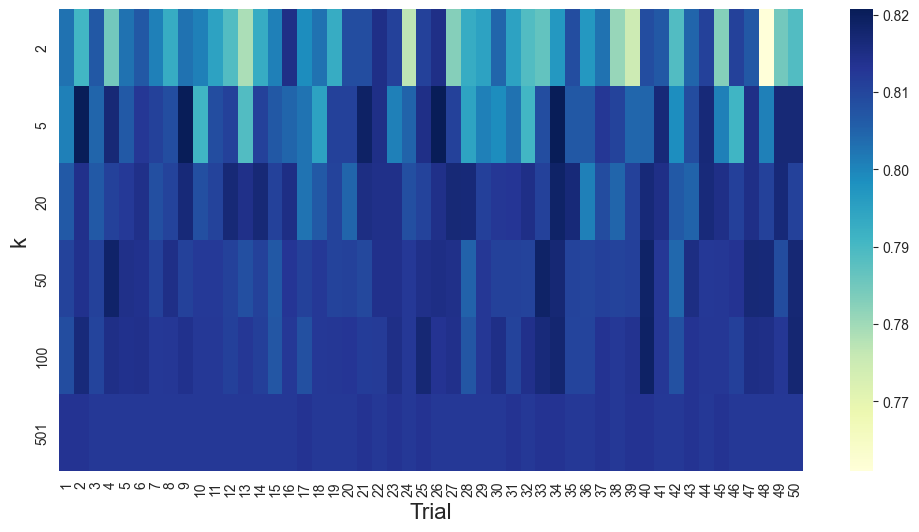

In [76]:
# Prepare data for heatmap
avg_dict = {}
for trial in accuracy_final_dict:
    avg_dict[trial] = {}
    for fold in accuracy_final_dict[trial]:
        indices = accuracy_final_dict[trial][fold].values()
        avg_value = sum(indices) / len(indices)
        # Store the average in the new dictionary
        avg_dict[trial][fold] = avg_value

avg_df = pd.DataFrame(avg_dict)

# Plotting the heat map
plt.figure(figsize=(12, 6))
sns.heatmap(avg_df, annot=False, cmap="YlGnBu", cbar=True)
plt.xlabel("Trial", fontsize=16)
plt.ylabel("k", fontsize=16)
plt.savefig('HeatmapCV.eps', format='eps')
plt.show()

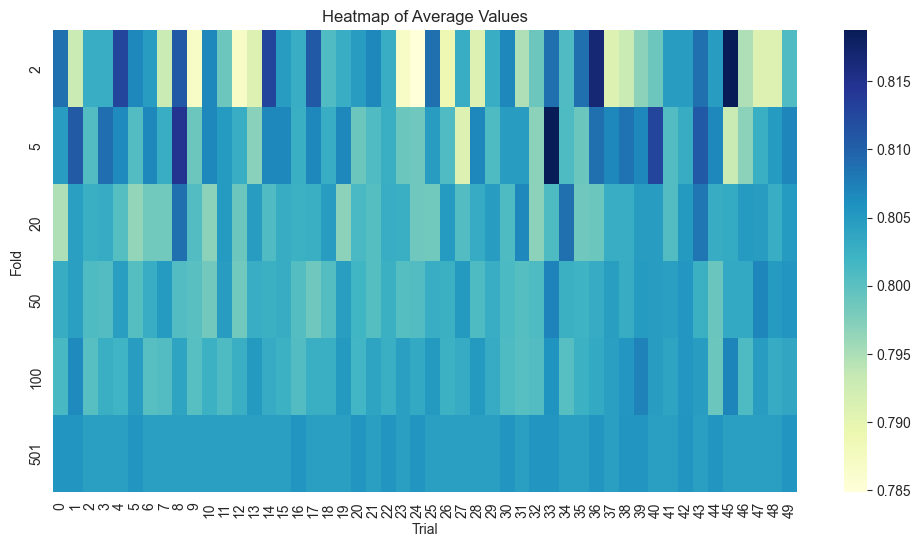

In [52]:
# Prepare data for heatmap
avg_dict = {}
for trial in accuracy_final_dict:
    avg_dict[trial] = {}
    for fold in accuracy_final_dict[trial]:
        indices = accuracy_final_dict[trial][fold].values()
        avg_value = sum(indices) / len(indices)
        # Store the average in the new dictionary
        avg_dict[trial][fold] = avg_value

avg_df = pd.DataFrame(avg_dict)

# Plotting the heat map
plt.figure(figsize=(12, 6))
sns.heatmap(avg_df, annot=False, cmap="YlGnBu", cbar=True)
plt.xlabel("Trial")
plt.ylabel("Fold")
plt.title("Heatmap of Average Accuracy")
plt.show()


# Final SVM Model

In [64]:
train_file_path = '../project_train.csv'
test_file_path = '../project_test.csv'

data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)

features_needed = ['speechiness', 'liveness', 'energy', 'loudness', 'valence']  # Based on the feature selection process described in the report

training_set = data_train[features_needed + ['Label']]

rows_to_remove = [68, 84, 94]  # 68: speechiness outlier, 84: energy false data, 94: loudness false data
print(f'Rows removed: \n {training_set.iloc[rows_to_remove]}')
training_set = training_set.drop(rows_to_remove)
training_set = training_set.reset_index(drop=True)

testing_set = data_test[features_needed]

# Transformation and scaling
vars_to_transform = [
    "energy",
    "speechiness",
    "liveness",
    "valence",
]

training_set_transformed = training_set.copy()
training_set_transformed[vars_to_transform] = training_set_transformed[vars_to_transform].transform(logit)
training_set_transformed[vars_to_transform + ['loudness']] = preprocessing.scale(training_set_transformed[vars_to_transform + ['loudness']])

testing_set_transformed = testing_set.copy()
testing_set_transformed[vars_to_transform] = testing_set_transformed[vars_to_transform].transform(logit)
testing_set_transformed[vars_to_transform + ['loudness']] = preprocessing.scale(testing_set_transformed[vars_to_transform + ['loudness']])

Rows removed: 
     speechiness  liveness   energy  loudness  valence  Label
68       0.9250     0.688    0.288   -13.843    0.772      0
84       0.0775     0.048  734.000    -4.551    0.963      1
94       0.0363     0.285    0.817 -6542.000    0.726      1


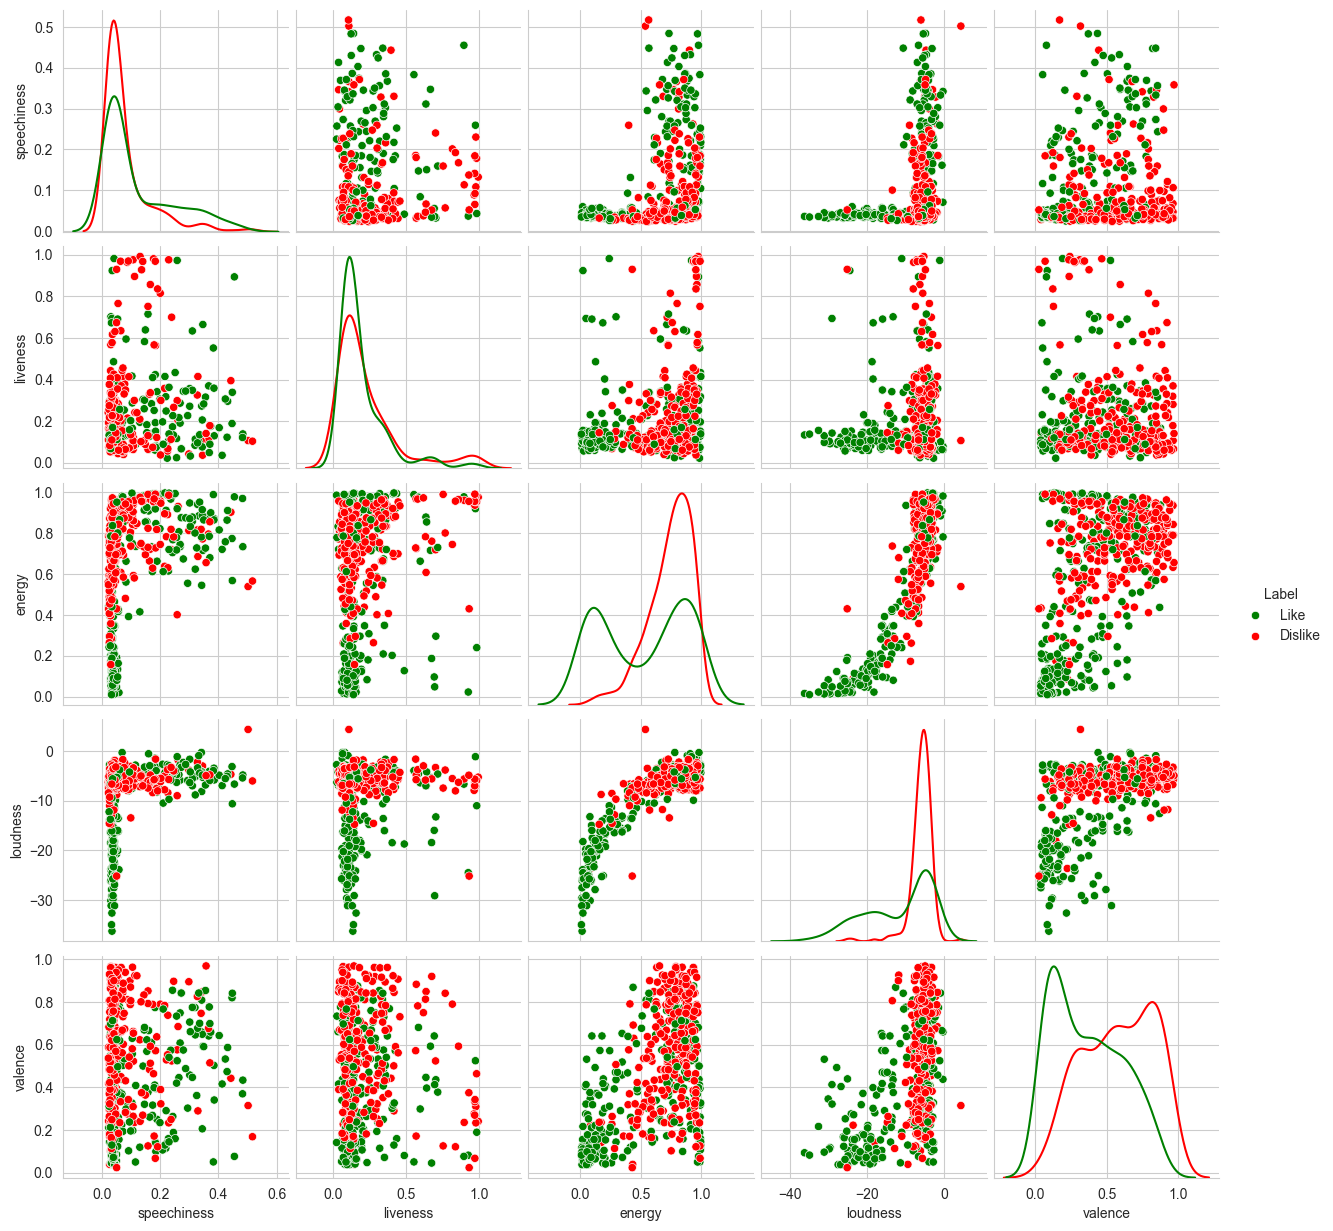

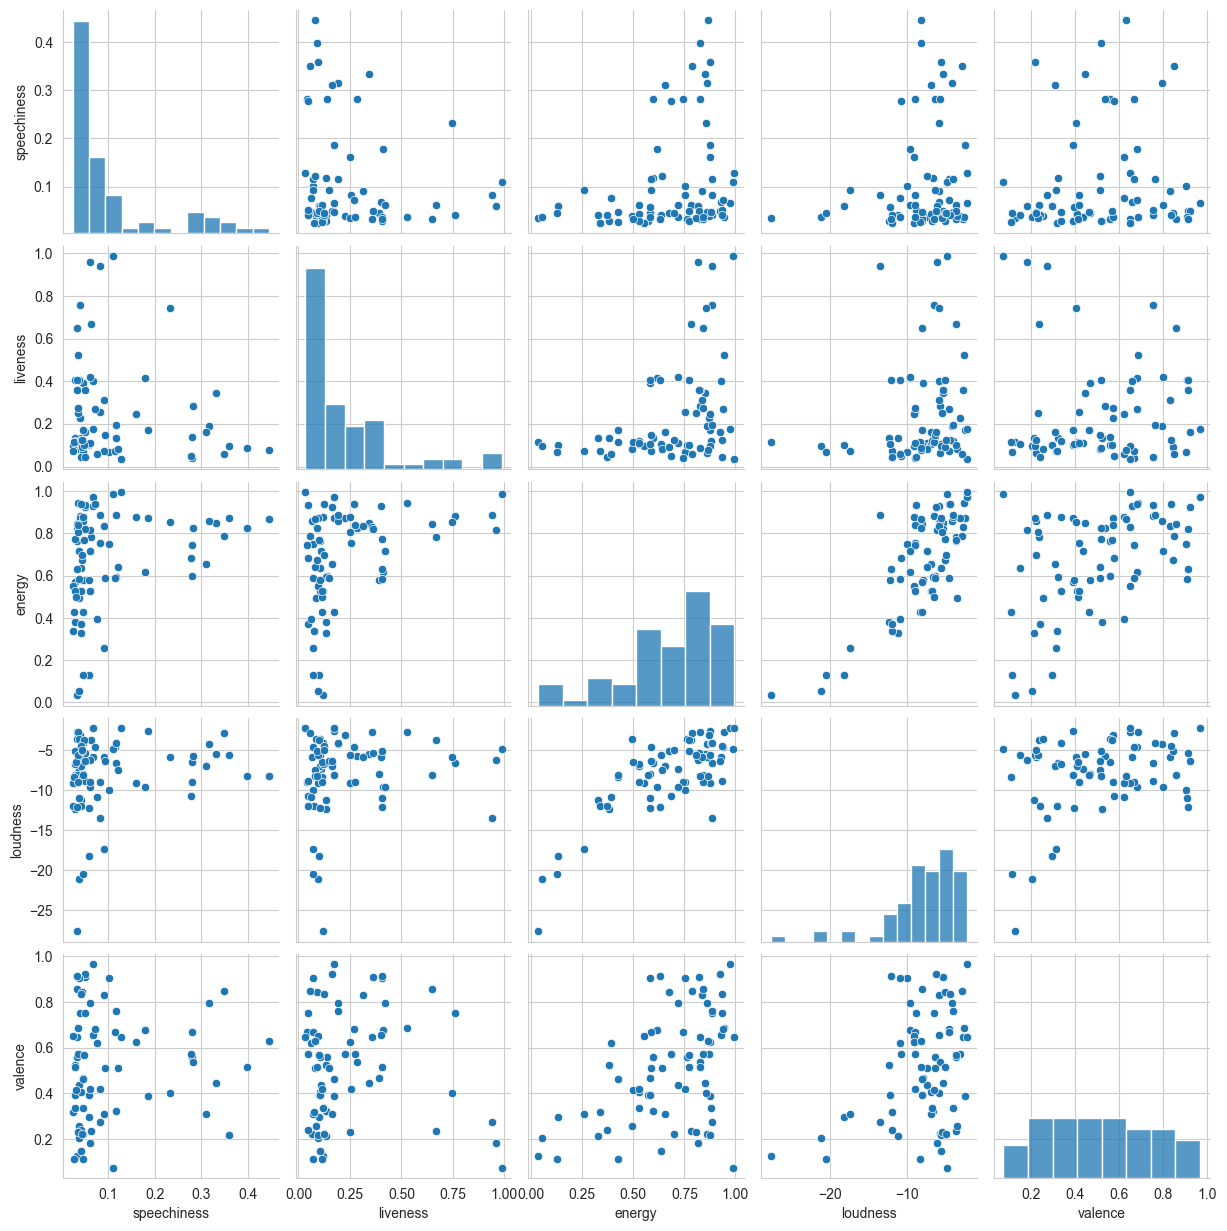

In [65]:
# Pair plot of original labelled data
display_train = training_set.copy()
display_train['Label'] = display_train['Label'].map({0: 'Dislike', 1: 'Like'})
 

sns.pairplot(display_train, hue="Label", diag_kws={'fill': False}, palette={'Dislike': 'red', 'Like': 'green'})
plt.show()

# Pair plot of original unlabelled data
sns.pairplot(testing_set, hue=None)
plt.show()

In [67]:
predictors_train = training_set_transformed[features_needed]
response_train = training_set_transformed['Label']

model = SVC(kernel='rbf', random_state=0, C=1, gamma=1)
model.fit(predictors_train, response_train)

response_pred = model.predict(testing_set_transformed)

data_test['Label_Pred'] = response_pred

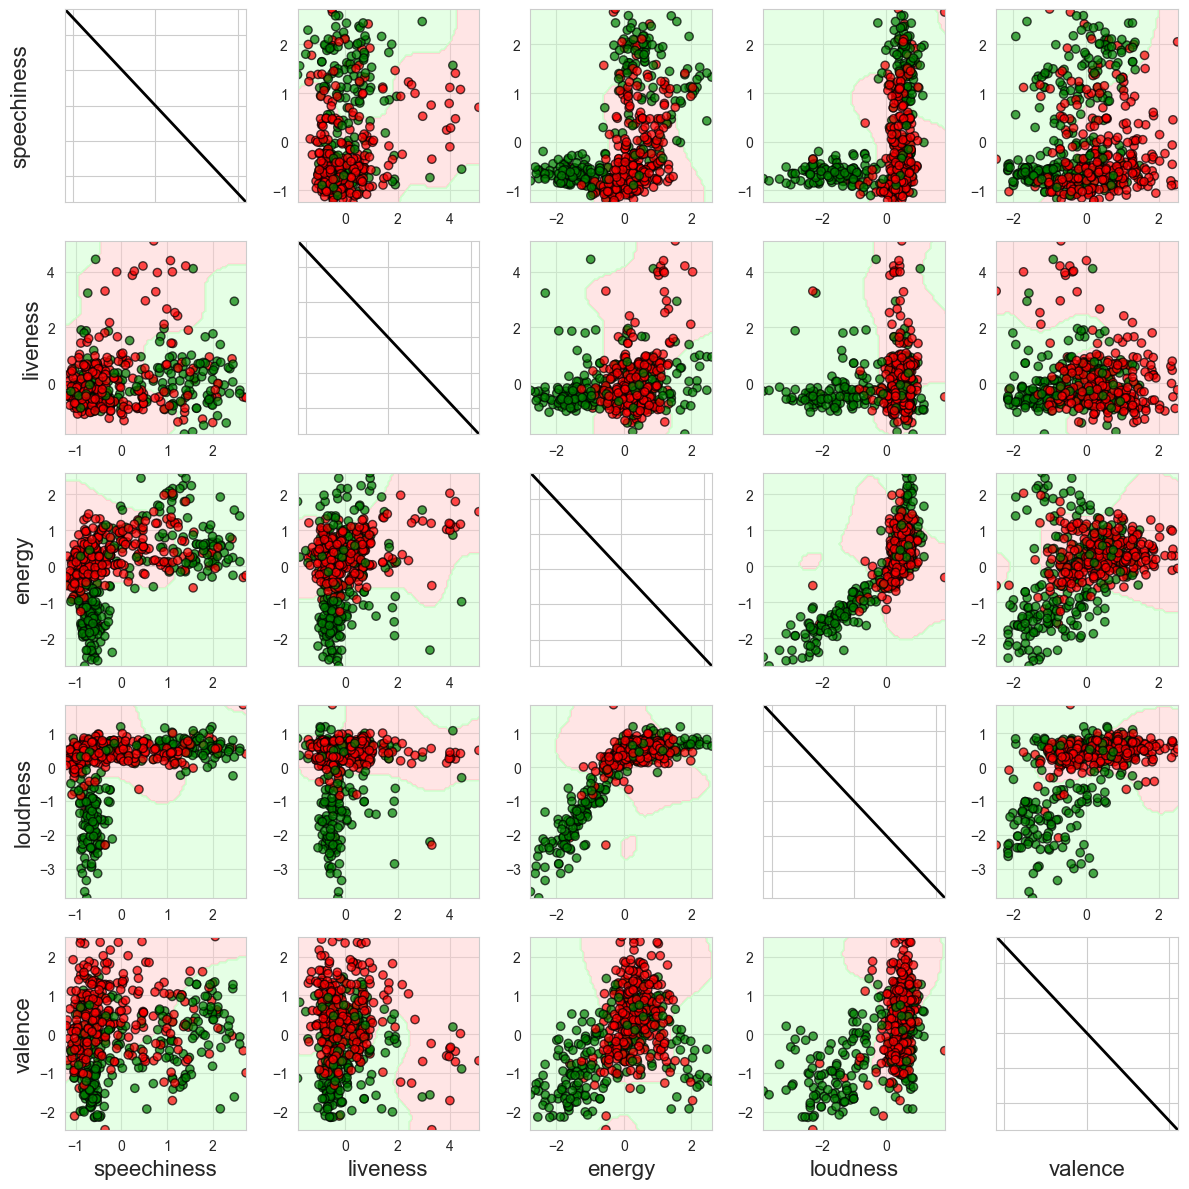

In [69]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(12, 12), sharex=False, sharey=False)

# Define custom colors for the classes
cmap_light = ListedColormap(['#ffcccc', '#ccffcc'])  # Light red and light green for decision boundaries
cmap_bold = ['red', 'green']  # Red and green for the points
formatter = FuncFormatter(lambda x, _: f'{abs(x):.1f}')

for i in range(len(predictors_train.columns)):
    for j in range(len(predictors_train.columns)):
        feature1 = j
        feature2 = i
        ax = axes[i, j]

        if i != j:
            X = predictors_train.to_numpy()[:, [feature1, feature2]]
            classifier = SVC(kernel='rbf', random_state=0, C=1, gamma=1).fit(X, response_train)

            disp = DecisionBoundaryDisplay.from_estimator(
                classifier, X, response_method="predict",
                xlabel=predictors_train.columns[feature1],
                ylabel=predictors_train.columns[feature2],
                alpha=0.5, ax=ax, cmap=cmap_light
            )

            ax.scatter(X[:, 0], X[:, 1], c=response_train, cmap=ListedColormap(cmap_bold), edgecolor="k", alpha=0.7)

            x_min, x_max = X[:, 0].min(), X[:, 0].max()
            y_min, y_max = X[:, 1].min(), X[:, 1].max()
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_min, y_max)
            ax.set_xlabel(predictors_train.columns[feature1], fontsize=16)
            ax.set_ylabel(predictors_train.columns[feature2], fontsize=16)
        else:
            ax.plot([0, 1], [1, 0], transform=ax.transAxes, color='black', linewidth=2)
            ax.set_xlabel(predictors_train.columns[feature1], fontsize=16)
            ax.set_ylabel(predictors_train.columns[feature2], fontsize=16)
            # ax.set_xticks([])
            # ax.set_yticks([])
            ax.tick_params(axis='x', colors='white')
            ax.tick_params(axis='y', colors='white')
            ax.xaxis.set_major_formatter(formatter)
            ax.yaxis.set_major_formatter(formatter)

        if j > 0:
            ax.set_ylabel('')

        if i < len(predictors_train.columns) - 1:
            ax.set_xlabel('')

plt.tight_layout()
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


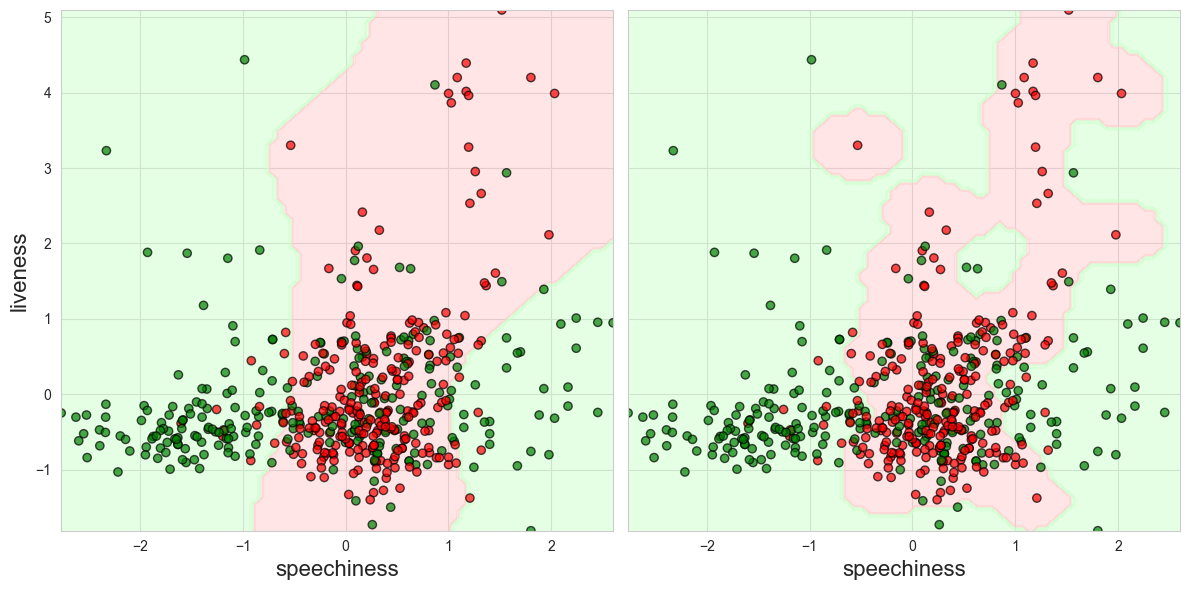

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharex=False, sharey=True)

X = predictors_train.to_numpy()[:, [2, 1]]
classifier = SVC(kernel='rbf', random_state=0).fit(X, response_train)
disp1 = DecisionBoundaryDisplay.from_estimator(
                classifier, X, response_method="predict",
                xlabel=predictors_train.columns[0],
                ylabel=predictors_train.columns[1],
                alpha=0.5, ax=axes[0], cmap=cmap_light
            )

axes[0].scatter(X[:, 0], X[:, 1], c=response_train, cmap=ListedColormap(cmap_bold), edgecolor="k", alpha=0.7)

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
axes[0].set_xlim(x_min, x_max)
axes[0].set_ylim(y_min, y_max)
axes[0].set_xlabel(predictors_train.columns[0], fontsize=16)
axes[0].set_ylabel(predictors_train.columns[1], fontsize=16)

classifier = SVC(kernel='rbf', random_state=0, C=1, gamma=10).fit(X, response_train)
disp2 = DecisionBoundaryDisplay.from_estimator(
                classifier, X, response_method="predict",
                xlabel=predictors_train.columns[0],
                ylabel=predictors_train.columns[1],
                alpha=0.5, ax=axes[1], cmap=cmap_light
            )

axes[1].scatter(X[:, 0], X[:, 1], c=response_train, cmap=ListedColormap(cmap_bold), edgecolor="k", alpha=0.7)

x_min, x_max = X[:, 0].min(), X[:, 0].max()
y_min, y_max = X[:, 1].min(), X[:, 1].max()
axes[1].set_xlim(x_min, x_max)
axes[1].set_ylim(y_min, y_max)
axes[1].set_xlabel(predictors_train.columns[0], fontsize=16)
axes[1].set_ylabel('')

plt.tight_layout()
plt.savefig('SVM_DecisionBoundaries_linVSrbf.eps', format='eps')
plt.show()

In [151]:
# Write results into CSV file

data_test.to_csv('project_test_predictions_SVM.csv', index=False)

In [161]:
# Testing final model accuracy

predictors_train, predictors_test, response_train, response_test = train_test_split(training_set_transformed[['danceability','speechiness', 'liveness', 'loudness']], training_set_transformed['Label'], test_size=0.2, random_state=0)

model, _ = svm_model('rbf', predictors_train, response_train, predictors_test, response_test)

accuracy_svm = accuracy_score(response_test, model.predict(predictors_test))
precision_svm = precision_score(response_test, model.predict(predictors_test))
recall_svm = recall_score(response_test, model.predict(predictors_test))
kappa_svm = cohen_kappa_score(response_test, model.predict(predictors_test))


Accuracy: 85.15%
Precision: 90.24%
Recall: 77.08%
Cohen's Kappa Score: 0.70


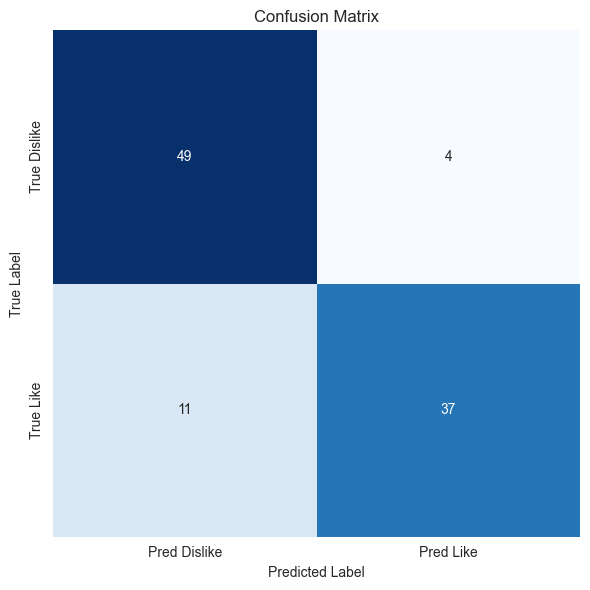

In [162]:
# Compute confusion matrix
cm_SVM = confusion_matrix(response_test, model.predict(predictors_test))

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(cm_SVM, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred Dislike', 'Pred Like'], yticklabels=['True Dislike', 'True Like'], cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()